In [2]:
#from mca_shared_izzy.mca_shared_si_drift_nsidc import first_dates_array_formatted
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')



In [4]:
# constant
rho_a = 1.225 # air density kg m-3
rho_w = 1000 #fresh water density kh m-3
rho_sw = 1027 # SW max density (https://essd.copernicus.org/articles/14/65/2022/essd-14-65-2022.pdf)

Cd_a = 1.5e-3 # drag coeff air
Cd_w = 5.5e-3 #drag coeff ice-water


In [5]:
gridtype = 'remapcon'

In [6]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
ds_monthly_sam = xr.open_dataset('monthly_sam.nc')
ds_seas_sam = xr.open_dataset('seas_sam.nc')

In [7]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 935kB
Dimensions:                       (time: 1, nv: 2, xc: 144, yc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 8B 1991-01-02T12:00:00
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 83kB ...
    lon                           (yc, xc) float32 83kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  int32 4B ...
    time_bnds                     (time, nv) datetime64[ns] 16B ...
    t0                            (time, yc, xc) datetime64[ns] 166kB ...
    t1                            (time, yc, xc) datetime64[ns] 166kB ...
    lat1                          (time, yc, xc) float32 83kB ...
    lon1                          (time, yc, xc) float32 83kB ...
    dX                            (time, yc, xc) float32 83kB ...
    dY                    

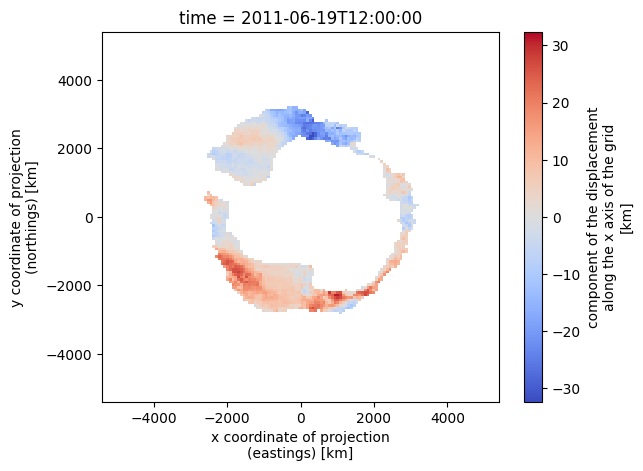

(144,)
(144,)


In [8]:
#sea ice drift data from eumetsat
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/eumetsat_sh_sid_data/"
ds_example = xr.open_dataset(directory + 'ice_drift_sh_ease2-750_cdr-v1p0_24h-199101021200.nc')
print(ds_example)
print(ds_example['xc'])

ds_example2 = xr.open_dataset(directory + 'ice_drift_sh_ease2-750_cdr-v1p0_24h-201106191200.nc')
print(ds_example2)
print(ds_example2['xc'])

variable_name = "dX"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name].isel(time=0)
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["xc"].shape)
print(ds_example2["yc"].shape)

In [9]:
print(ds_example2["dX"].attrs)

{'long_name': 'component of the displacement along the x axis of the grid', 'standard_name': 'sea_ice_x_displacement', 'units': 'km', 'grid_mapping': 'Lambert_Azimuthal_Equal_Area', 'ancillary_variables': 'uncert_dX_and_dY status_flag'}


In [10]:
print(ds_example2.variables)


Frozen({'Lambert_Azimuthal_Equal_Area': <xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   -90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lat_0=-90 +lon_0=0 +x_0=0 +y..., 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2011-06-19T12:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    axis:           T
    long_name:      reference time of product
    standard_name:  time
    bounds:         time_bnds
    comment:        The time scalar dimension holds the date of _end_ of motion., 'time_bnds': <xarray.Variable (time: 1, nv: 2)> Size: 16B
[2 values with dtype=datetime64[ns]], 'xc': <xarray.IndexVariable 'xc' (xc: 144)>

In [11]:
ds_check = xr.open_dataset('sid_eumetsat_sh.nc')
print(ds_check)

<xarray.Dataset> Size: 8GB
Dimensions:                       (time: 10958, nv: 2, yc: 144, xc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 88kB 1991-01-01T12:00...
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 83kB ...
    lon                           (yc, xc) float32 83kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  (time) int32 44kB ...
    time_bnds                     (time, nv) datetime64[ns] 175kB ...
    t0                            (time, yc, xc) datetime64[ns] 2GB ...
    t1                            (time, yc, xc) datetime64[ns] 2GB ...
    lat1                          (time, yc, xc) float32 909MB ...
    lon1                          (time, yc, xc) float32 909MB ...
    dX                            (time, yc, xc) float32 909MB ...
    dY      

In [12]:
ds_eumetsat_drift = xr.open_dataset('sid_eumetsat_sh.nc')
print(ds_eumetsat_drift)

<xarray.Dataset> Size: 8GB
Dimensions:                       (time: 10958, nv: 2, yc: 144, xc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 88kB 1991-01-01T12:00...
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 83kB ...
    lon                           (yc, xc) float32 83kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  (time) int32 44kB ...
    time_bnds                     (time, nv) datetime64[ns] 175kB ...
    t0                            (time, yc, xc) datetime64[ns] 2GB ...
    t1                            (time, yc, xc) datetime64[ns] 2GB ...
    lat1                          (time, yc, xc) float32 909MB ...
    lon1                          (time, yc, xc) float32 909MB ...
    dX                            (time, yc, xc) float32 909MB ...
    dY      

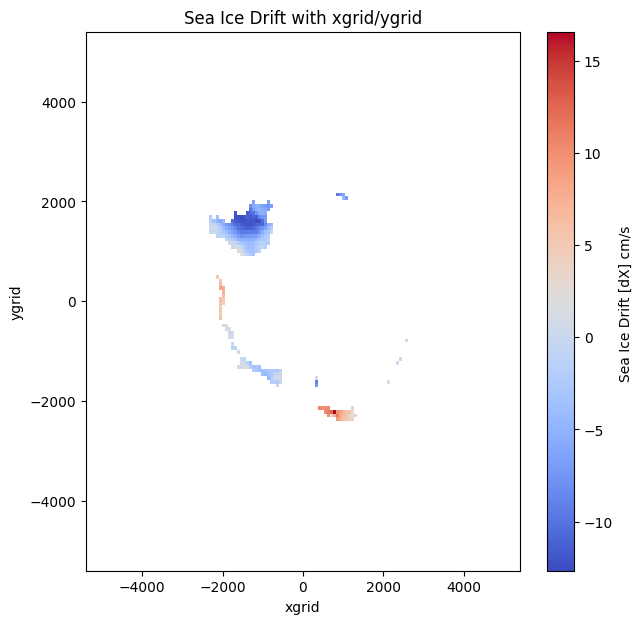

In [13]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_eumetsat_drift["dX"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_eumetsat_drift["xc"],
    ds_eumetsat_drift["yc"],
    data_to_plot.isel(time=1156),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [dX] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("xgrid")
plt.ylabel("ygrid")
plt.show()


In [14]:
print("Data shape:", ds_eumetsat_drift["dX"].isel(time=1156).shape)
print("Longitude shape:", ds_eumetsat_drift["lon"].shape)
print("Latitude shape:", ds_eumetsat_drift["lat"].shape)


Data shape: (144, 144)
Longitude shape: (144, 144)
Latitude shape: (144, 144)


In [15]:
print(ds_eumetsat_drift["lon"])
print(ds_eumetsat_drift["dX"].values)

<xarray.DataArray 'lon' (yc: 144, xc: 144)> Size: 83kB
[20736 values with dtype=float32]
Coordinates:
  * xc       (xc) float64 1kB -5.362e+03 -5.288e+03 ... 5.288e+03 5.362e+03
  * yc       (yc) float64 1kB 5.362e+03 5.288e+03 ... -5.288e+03 -5.362e+03
    lat      (yc, xc) float32 83kB ...
    lon      (yc, xc) float32 83kB ...
Attributes:
    long_name:      longitude coordinate
    standard_name:  longitude
    units:          degrees_east
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ...

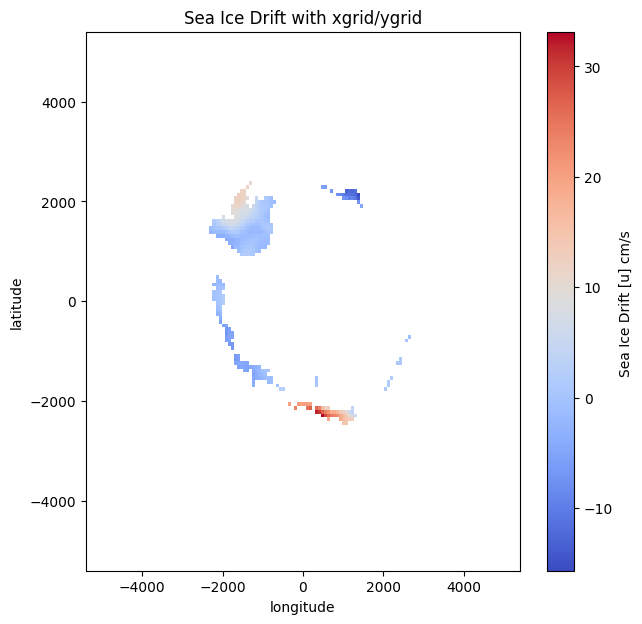

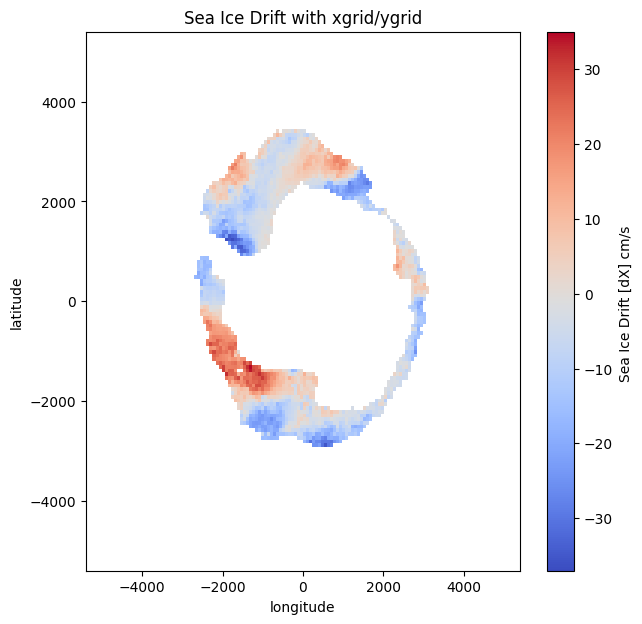

In [16]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_eumetsat_drift["dX"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_eumetsat_drift["xc"],
    ds_eumetsat_drift["yc"],
    data_to_plot.isel(time=1115),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_eumetsat_drift["xc"],
    ds_eumetsat_drift["yc"],
    data_to_plot.isel(time=2000),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [dX] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [17]:
print(ds_eumetsat_drift["lat1"].dims)
print(ds_eumetsat_drift["lon1"].dims)

('time', 'yc', 'xc')
('time', 'yc', 'xc')


In [18]:
print(ds_eumetsat_drift.values)
print("Lon shape", ds_eumetsat_drift['lon1'].shape)
print("Lat shape", ds_eumetsat_drift['lon1'].shape)

# Compute the max and min values
lon_values = ds_eumetsat_drift['lon1'].values  # Extract as a NumPy array
lon_max = np.max(lon_values)
lon_min = np.min(lon_values)

# Print the results
print(f"Longitude Min: {lon_min}, Longitude Max: {lon_max}")

<bound method Mapping.values of <xarray.Dataset> Size: 8GB
Dimensions:                       (time: 10958, nv: 2, yc: 144, xc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 88kB 1991-01-01T12:00...
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 83kB ...
    lon                           (yc, xc) float32 83kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  (time) int32 44kB ...
    time_bnds                     (time, nv) datetime64[ns] 175kB ...
    t0                            (time, yc, xc) datetime64[ns] 2GB ...
    t1                            (time, yc, xc) datetime64[ns] 2GB ...
    lat1                          (time, yc, xc) float32 909MB ...
    lon1                          (time, yc, xc) float32 909MB ...
    dX                            (time, yc, xc

In [19]:
print(ds_eumetsat_drift["time"].dtype)
print(ds_eumetsat_drift["time"])

datetime64[ns]
<xarray.DataArray 'time' (time: 10958)> Size: 88kB
array(['1991-01-01T12:00:00.000000000', '1991-01-02T12:00:00.000000000',
       '1991-01-03T12:00:00.000000000', ..., '2020-12-29T12:00:00.000000000',
       '2020-12-30T12:00:00.000000000', '2020-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 88kB 1991-01-01T12:00:00 ... 2020-12-31T12...
Attributes:
    axis:           T
    long_name:      reference time of product
    standard_name:  time
    bounds:         time_bnds
    comment:        The time scalar dimension holds the date of _end_ of motion.


In [20]:
# Convert time to datetime64[ns] using astype()
ds_eumetsat_drift["time"] = ds_eumetsat_drift["time"].astype('datetime64[ns]')


In [21]:
print(ds_eumetsat_drift["time"].dtype)
time_check = ds_eumetsat_drift["time"].values
print(time_check)

datetime64[ns]
['1991-01-01T12:00:00.000000000' '1991-01-02T12:00:00.000000000'
 '1991-01-03T12:00:00.000000000' ... '2020-12-29T12:00:00.000000000'
 '2020-12-30T12:00:00.000000000' '2020-12-31T12:00:00.000000000']


In [22]:
time_eumetsat_drift = ds_eumetsat_drift['time'].values
print("eumetsat drift time", time_eumetsat_drift[1274],time_eumetsat_drift[2119])

eumetsat drift time 1994-06-28T12:00:00.000000000 1996-10-20T12:00:00.000000000


In [23]:
ds_check['dX'].shape
ds_check['dY'].shape

(10958, 144, 144)

In [24]:
## reorder ds_nsidc_drift  to have time_new, lat, lon
#
# # Open the dataset
# ds_nsidc_drift = xr.open_dataset("si_drift_nsidc.nc")
#
# # Step 1: Extract lat, lon, and sea ice concentration
# lat_nsidc_drift = ds_nsidc_drift['latitude'].isel(time=0).values  # Shape (time,y, x)
# lon_nsidc_drift = ds_nsidc_drift['longitude'].isel(time=0).values # Shape (time,y, x)
# time_new_drift = ds_nsidc_drift['time'].values  # Shape (time_new)
#
# # Step 2: Flatten the lat and lon arrays into 1D arrays
# lat_flat = lat_nsidc_drift.flatten()
# lon_flat = lon_nsidc_drift.flatten()
#
# # Step 3: Reshape the variable to match the flattened grid
# var_u = ds_check['u'].values  # Shape (time_new, tdim, y, x)
# var_v = ds_check['v'].values
#
# # # Remove 'tdim' dimension by squeezing it
# # var_u_squeezed = var_u[:, 0, :, :]  # Shape becomes (time_new, y, x)
#
# # Flatten 'y' and 'x' into a single dimension
# var_u_flat = var_u.reshape((var_u.shape[0], -1))  # Shape (time_new, y*x)
# var_v_flat = var_v.reshape((var_v.shape[0], -1))  # Shape (time_new, y*x)
#
# # Step 4: Create a new dataset with dimensions (time_new, lat, lon)
# ds_reordered = xr.Dataset(
#     data_vars={
#         'u': (['time_new', 'points'], var_u_flat),  # Data flattened
#         'v': (['time_new', 'points'], var_v_flat),
#     },
#     coords={
#         'time_new': time_new_drift,      # Time dimension
#         'lat': ('points', lat_flat),  # 1D lat coordinate
#         'lon': ('points', lon_flat)   # 1D lon coordinate
#     }
# )
#
# # Step 5: Verify the new dataset
# print(ds_reordered)
#
# # Step 6: Save the new dataset
# output_file = "reordered_sea_ice_drift.nc"
# ds_reordered.to_netcdf(output_file)
# print(f"Reordered dataset saved to: {output_file}")


In [25]:
5+5

10

In [26]:
# # Compute the max and min values
# ds_check_2 = xr.open_dataset('reordered_sea_ice_drift.nc')
#
# lon_values = ds_check_2['lon'].values  # Extract as a NumPy array
# lon_max = np.max(lon_values)
# lon_min = np.min(lon_values)
#
# # Print the results
# print(f"Longitude Min: {lon_min}, Longitude Max: {lon_max}")
#
# print(f"Number of points: {lat_flat.shape[0]} (should be equal to y * x)")
# print(f"Sea Ice Drift u reshaped to: {var_u_flat.shape}")
# print(321*321)



In [27]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [28]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [29]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


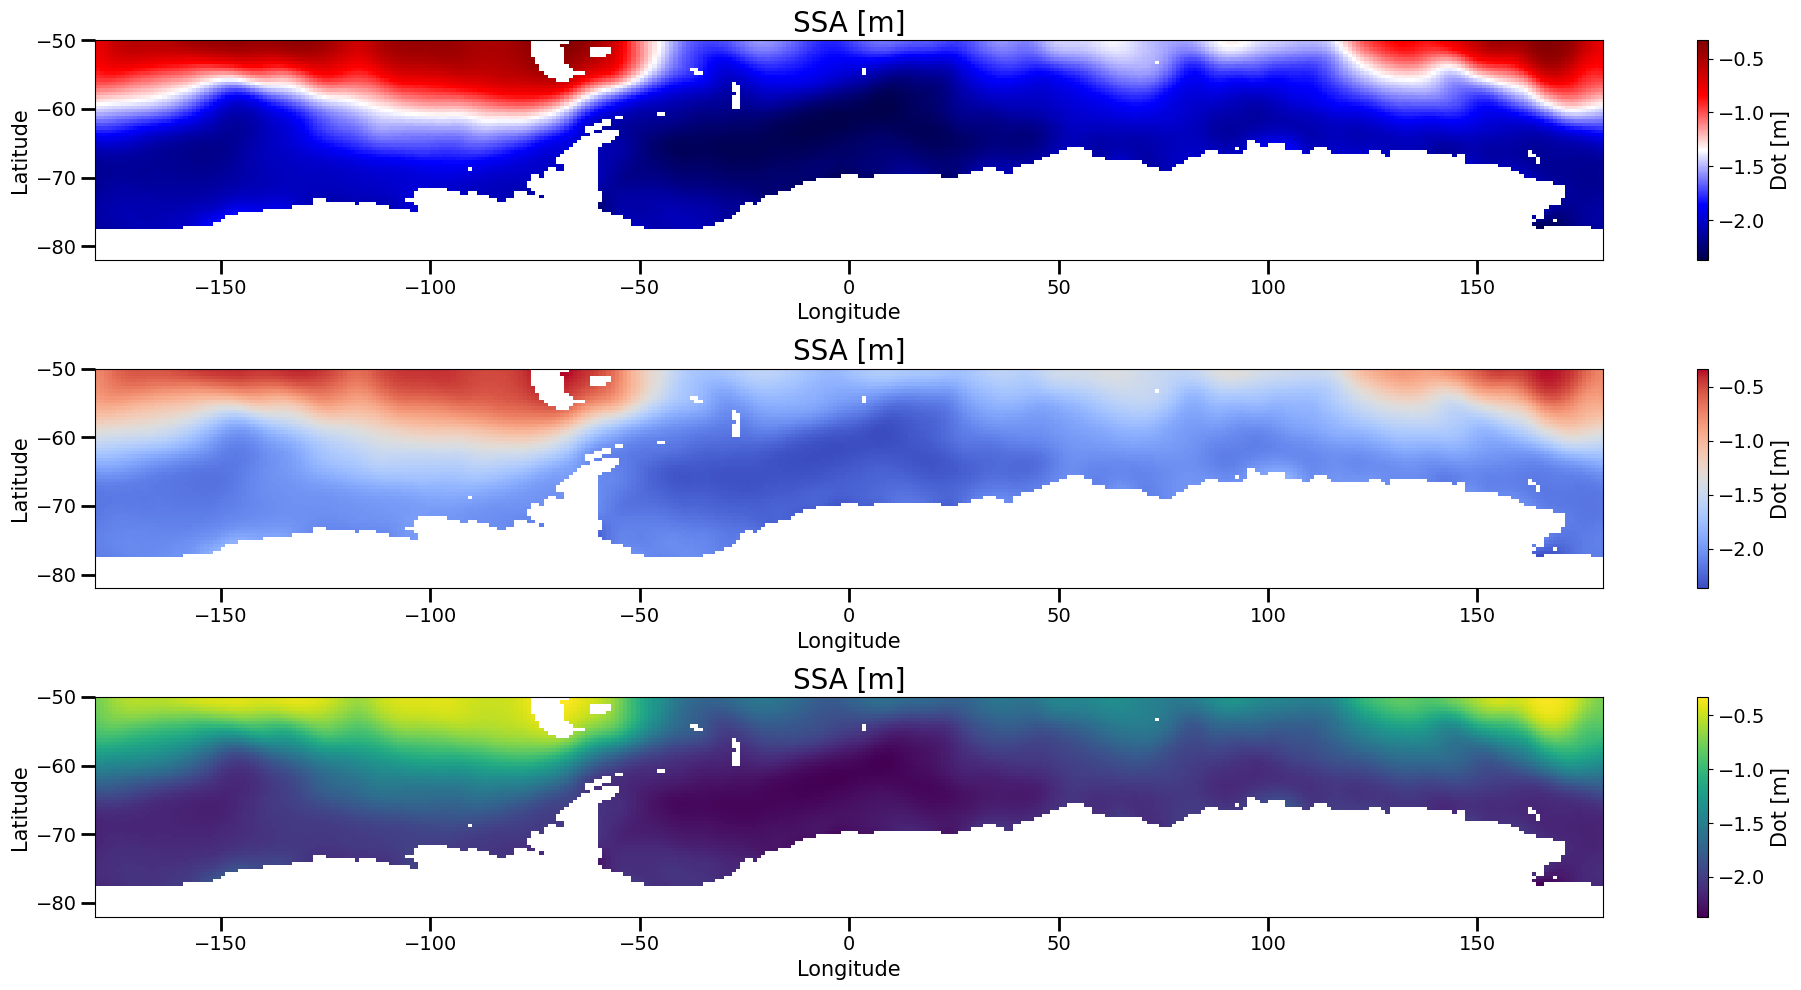

In [30]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [31]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_eumetsat_drift = ds_eumetsat_drift['time'].values

In [32]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_eumetsat_drift = np.array(time_eumetsat_drift, dtype='datetime64[ns]')

indices_dot_eumetsat = np.where(np.isin(time_eumetsat_drift, time_dot_array))
print(indices_dot_eumetsat)

(array([], dtype=int64),)


In [33]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("nsidc drift time", time_eumetsat_drift[1274],time_eumetsat_drift[2119])

print(225-30)
2219-1274

dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
nsidc drift time 1994-06-28T12:00:00.000000000 1996-10-20T12:00:00.000000000
195


945

In [34]:
print(type(ds_eumetsat_drift.indexes['time']))  # Should show CFTimeIndex

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [35]:
# Check the time index type
print(type(ds_eumetsat_drift.indexes['time']))  # Should show CFTimeIndex

# Check the type of the current time index
if isinstance(ds_eumetsat_drift.indexes['time'], xr.CFTimeIndex):
    print("Converting CFTimeIndex to DatetimeIndex...")

    # Convert CFTimeIndex to DatetimeIndex
    datetimeindex = ds_eumetsat_drift.indexes['time'].to_datetimeindex()

    # Replace the time coordinate with the new DatetimeIndex
    ds_nsidc_drift = ds_eumetsat_drift.assign_coords(time=datetimeindex)

    # Verify the new time coordinate type
    print("Updated time index type:", type(ds_eumetsat_drift.indexes['time']))  # Should now show DatetimeIndex
    print("Updated time coordinate values:")
    print(ds_eumetsat_drift['time'])
else:
    print("The time index is already a DatetimeIndex or incompatible type.")
    print("Current time index type:", type(ds_eumetsat_drift.indexes['time']))



<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
The time index is already a DatetimeIndex or incompatible type.
Current time index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


need to finish updating this to make it monthly average

In [36]:
print(ds_eumetsat_drift['time'].shape)
print(ds_eumetsat_drift['time'].dtype)
print(ds_eumetsat_drift['dX'].dims)
print(ds_eumetsat_drift.dims)


(10958,)
datetime64[ns]
('time', 'yc', 'xc')
FrozenMappingWarningOnValuesAccess({'time': 10958, 'nv': 2, 'yc': 144, 'xc': 144})


In [37]:
import pandas as pd
import xarray as xr

# Convert the time coordinate to pandas DatetimeIndex
time_index = pd.to_datetime(ds_eumetsat_drift['time'].values)

# List to store the first date of each month and the averages
monthly_averages_dX = []
monthly_averages_dY = []
new_month = []

# Iterate through the datetime array to group by month
for current_month in time_index.to_period('M').unique():  # Loop through each unique month
    # Get the indices for the current month
    month_mask = time_index.to_period('M') == current_month

    # Select the data for the current month and average across time
    monthly_dX = ds_eumetsat_drift['dX'][month_mask].mean(dim='time')  # Average dX
    monthly_dY = ds_eumetsat_drift['dY'][month_mask].mean(dim='time')  # Average dY

    # Store the monthly averages
    monthly_averages_dX.append(monthly_dX)
    monthly_averages_dY.append(monthly_dY)

    # Store the first date of the current month (arbitrary time step)
    new_month.append(current_month.start_time)

# Create a new time coordinate with the first of each month
new_time = pd.to_datetime(new_month)

# Create new xarray DataArrays for the averaged dX and dY values
monthly_avg_dX = xr.DataArray(
    monthly_averages_dX,
    dims=("time", "yc", "xc"),
    coords={
        "time": new_time,
        "lat": ds_eumetsat_drift['lat'],  # Correct latitude dimension
        "lon": ds_eumetsat_drift['lon'],  # Correct longitude dimension
    },
    name="dX",  # Keeping the original name for dX
)

monthly_avg_dY = xr.DataArray(
    monthly_averages_dY,
    dims=("time", "yc", "xc"),
    coords={
        "time": new_time,
        "lat": ds_eumetsat_drift['lat'],  # Correct latitude dimension
        "lon": ds_eumetsat_drift['lon'],  # Correct longitude dimension
    },
    name="dY",  # Keeping the original name for dY
)

# Create a new Dataset with both monthly average dX and dY
subset_ds = xr.Dataset(
    {
        "dX": monthly_avg_dX,  # Storing monthly averaged dX
        "dY": monthly_avg_dY,  # Storing monthly averaged dY
    }
)

# Verify the new dataset
print(subset_ds)


<xarray.Dataset> Size: 60MB
Dimensions:  (time: 360, yc: 144, xc: 144)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2020-12-01
    lat      (yc, xc) float32 83kB -17.02 -17.61 -18.2 ... -18.2 -17.61 -17.02
    lon      (yc, xc) float32 83kB -45.0 -44.6 -44.19 ... 135.8 135.4 135.0
Dimensions without coordinates: yc, xc
Data variables:
    dX       (time, yc, xc) float32 30MB nan nan nan nan nan ... nan nan nan nan
    dY       (time, yc, xc) float32 30MB nan nan nan nan nan ... nan nan nan nan


In [38]:

print(subset_ds['time'].dtype)


datetime64[ns]


In [39]:
print(ds_eumetsat_drift['time'].shape)
print(ds_eumetsat_drift['dX'].shape)
print(ds_eumetsat_drift['dY'].shape)
print(ds_eumetsat_drift['xc'].shape)
print(ds_eumetsat_drift['lon'].shape)

print(subset_ds['time'].shape)
print(subset_ds['dX'].shape)
print(subset_ds['dY'].shape)
print(subset_ds['xc'].shape)
print(subset_ds['lon'].shape)




(10958,)
(10958, 144, 144)
(10958, 144, 144)
(144,)
(144, 144)
(360,)
(360, 144, 144)
(360, 144, 144)
(144,)
(144, 144)


In [40]:
first_dates_array_formatted = pd.Series(subset_ds['time'].values)

In [41]:
print(ds_eumetsat_drift.dims)
print(ds_eumetsat_drift.coords)
print(ds_eumetsat_drift.var)

print(subset_ds.dims)
print(subset_ds.coords)
print(subset_ds.var)

FrozenMappingWarningOnValuesAccess({'time': 10958, 'nv': 2, 'yc': 144, 'xc': 144})
Coordinates:
  * time     (time) datetime64[ns] 88kB 1991-01-01T12:00:00 ... 2020-12-31T12...
  * xc       (xc) float64 1kB -5.362e+03 -5.288e+03 ... 5.288e+03 5.362e+03
  * yc       (yc) float64 1kB 5.362e+03 5.288e+03 ... -5.288e+03 -5.362e+03
    lat      (yc, xc) float32 83kB ...
    lon      (yc, xc) float32 83kB ...
<bound method DatasetAggregations.var of <xarray.Dataset> Size: 8GB
Dimensions:                       (time: 10958, nv: 2, yc: 144, xc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 88kB 1991-01-01T12:00...
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 83kB ...
    lon                           (yc, xc) float32 83kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  (

In [42]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
#time_nsidc_array = np.array(first_dates_array_formatted, dtype='datetime64[ns]')
time_subset_array = np.array(subset_ds['time'], dtype='datetime64[ns]')

# print(time_subset_array)
# print(time_dot_array)

# indices_dot_nsidc = np.where(np.isin(time_nsidc_array, time_dot_array))
indices_dot_eumetsat = np.where(np.isin(time_subset_array, time_dot_array))
print(indices_dot_eumetsat)
#print(time_era5)
print("dot time", time_dot[0], time_dot[-1])
print("era5 time", time_era5[30], time_era5[225])
print("eumetsat drift time", first_dates_array_formatted[138], first_dates_array_formatted[333])

print(225 - 30)
print(333-138)

(array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 3

In [43]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

tstart_eumetsat = 138
tend_eumetsat = 334 #+1 respect cell above

In [44]:
# select sea ice drift u
#seaice_drift_u = ds_nsidc_drift['u'][tstart_nsidc:tend_nsidc].values
seaice_drift_dX = subset_ds['dX'][tstart_eumetsat:tend_eumetsat].values
print(seaice_drift_dX.shape)
print(seaice_drift_dX)

# select sea ice drift v
#seaice_drift_v = ds_nsidc_drift['v'][tstart_nsidc:tend_nsidc].values
seaice_drift_dY = subset_ds['dY'][tstart_eumetsat:tend_eumetsat].values
print(seaice_drift_dY.shape)
print(seaice_drift_dY)

(196, 144, 144)
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan n

In [45]:
print(seaice_drift_dX.shape)
print(seamask.shape)

(196, 144, 144)
(64, 360)


In [46]:
# DE-TREND DOT

In [47]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

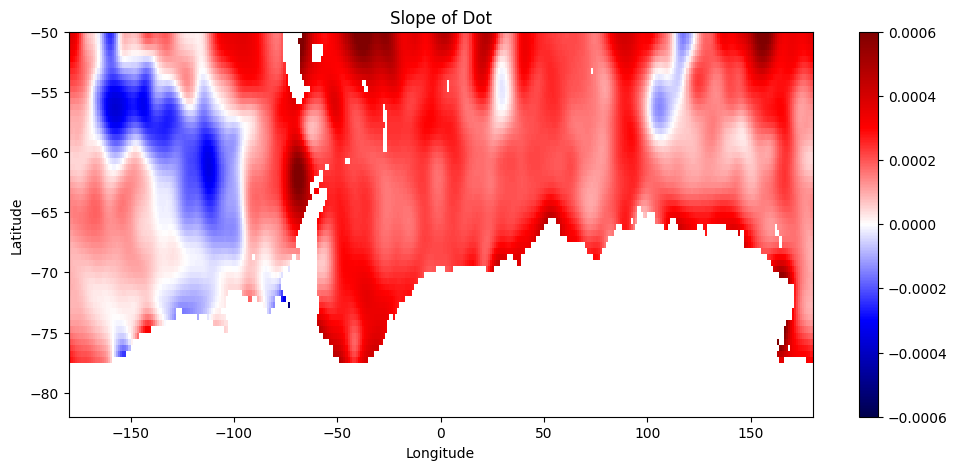

In [48]:

plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [49]:
dot_final = dot_detrended.copy()

In [50]:
seaice_dX = subset_ds['dX'][tstart_eumetsat:tend_eumetsat].values
seaice_dY = subset_ds['dY'][tstart_eumetsat:tend_eumetsat].values

print(seaice_dX.shape,np.isnan(seaice_dX).sum() )
print(seaice_dY.shape, np.isnan(seaice_dY).sum())

# Assuming 'time_new' is the time coordinate in the dataset
time_values = subset_ds['time'][tstart_eumetsat:tend_eumetsat].values
print(time_values.shape)  # To verify the shape
#print(time_values)


(196, 144, 144) 3679342
(196, 144, 144) 3679342
(196,)


In [51]:
print(seaice_dX.shape)
print((seaice_dX).shape[0])
print((seaice_dX[0]).shape)


(196, 144, 144)
196
(144, 144)


In [52]:
lat_eumetsat_drift = subset_ds['lat'].values  # Shape (time,y, x)
lon_eumetsat_drift = subset_ds['lon'].values # Shape (time,y, x)

print(lon_eumetsat_drift.shape)
print(lat_eumetsat_drift.shape)

(144, 144)
(144, 144)


In [53]:
print(seaice_drift_dX.shape)
print(seaice_drift_dX[0].shape)
print(seaice_dX.shape[0])

print(seaice_drift_dX.shape)
print((seaice_drift_dX).shape[0])

(196, 144, 144)
(144, 144)
196
(196, 144, 144)
196


In [54]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_u = []
regridded_data_v = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_drift_dX.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (321, 321)
    seaice_u = seaice_drift_dX[t]
    seaice_v = seaice_drift_dY[t]

    # Coordinates for the original grid
    lon_seaice = lon_eumetsat_drift  # (321, 321)
    lat_seaice = lat_eumetsat_drift  # (321, 321)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    values_u =  seaice_u.flatten()
    values_v = seaice_v.flatten()

    # print(points.shape)
    # print(values.shape)

    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded_u = griddata(points, values_u, (lon_mesh, lat_mesh), method='linear')
    seaice_regridded_v = griddata(points, values_v, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_u.append(seaice_regridded_u)
    regridded_data_v.append(seaice_regridded_v)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_drift_u = np.stack(regridded_data_u, axis=0)  # Shape: (time, lat, lon)
regridded_seaice_drift_v = np.stack(regridded_data_v, axis=0)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape u: {regridded_seaice_drift_u.shape}")
print(f"Regridded data shape v: {regridded_seaice_drift_u.shape}")
#print(f"Time steps: {time_steps_list}")


Regridded data shape u: (196, 64, 360)
Regridded data shape v: (196, 64, 360)


In [55]:
# Create new xarray DataArrays for regridded 'u' and 'v' data
regridded_seaice_da_u = xr.DataArray(
    regridded_seaice_drift_u,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_u",  # Variable name for 'u'
)

regridded_seaice_da_v = xr.DataArray(
    regridded_seaice_drift_v,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_v",  # Variable name for 'v'
)

# Create a single Dataset with both regridded DataArrays
regridded_seaice_ds = xr.Dataset(
    {
        "seaice_drift_u": regridded_seaice_da_u,
        "seaice_drift_v": regridded_seaice_da_v,
    }
)

# Print dataset to verify
print(regridded_seaice_ds)



<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


In [56]:
print(regridded_seaice_ds['seaice_drift_u'].shape)

(196, 64, 360)


<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


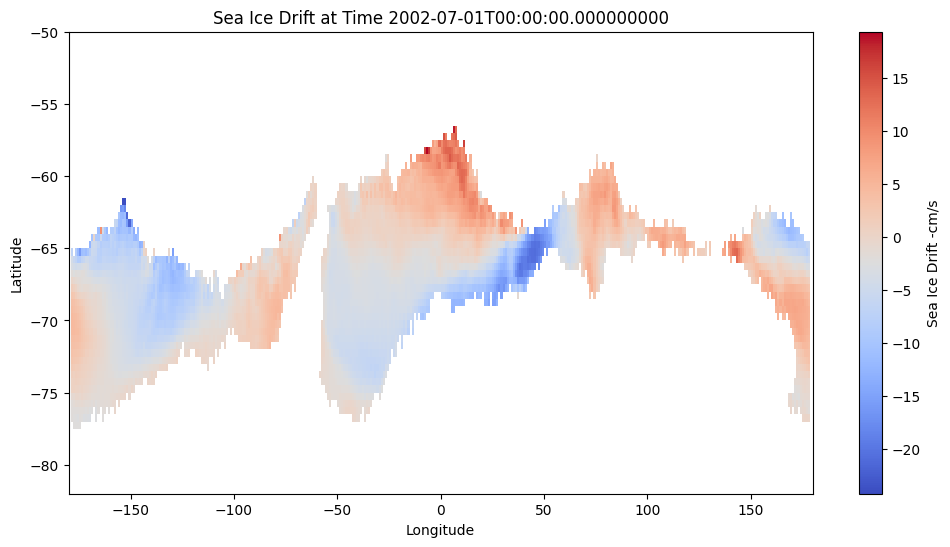

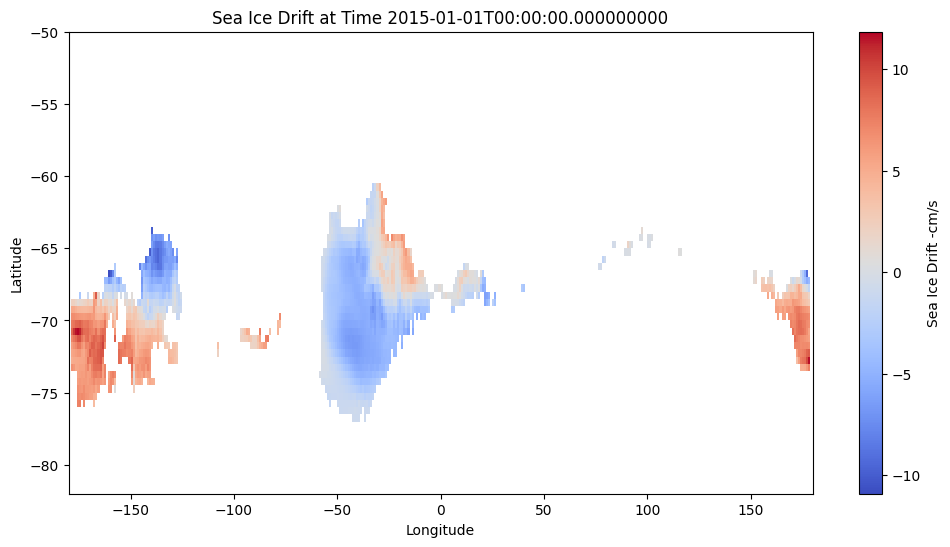

In [57]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values
time_step = 0

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=time_step), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[0]}')  # Use time label for title
plt.show()

plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=150), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[150]}')  # Use time label for title
plt.show()

In [58]:
time_step = 0
# Select the data at the specified time step
seaice_drift_u_at_time = regridded_seaice_ds['seaice_drift_u'].isel(time=time_step)
seaice_drift_v_at_time = regridded_seaice_ds['seaice_drift_v'].isel(time=time_step)

# Create the ice mask by dividing by itself and setting zeros to NaN
icemask_u = seaice_drift_u_at_time / seaice_drift_u_at_time
icemask_u = icemask_u.where(icemask_u != 0, np.nan)  # Replace zeros with NaN

icemask_v = seaice_drift_v_at_time / seaice_drift_v_at_time
icemask_v = icemask_v.where(icemask_v != 0, np.nan)  # Replace zeros with NaN



In [59]:
#apply the icemask
# Apply the masks to the u and v components across the entire time dimension
seaice_masked_u = regridded_seaice_ds['seaice_drift_u'] * icemask_u
seaice_masked_v = regridded_seaice_ds['seaice_drift_v'] * icemask_v

# Create a new dataset with masked values
seaice_drift_masked_ds = xr.Dataset(
    {
        'seaice_drift_u_masked': seaice_masked_u,
        'seaice_drift_v_masked': seaice_masked_v
    },
    coords=regridded_seaice_ds.coords
)

# Print the resulting dataset to verify
print(seaice_drift_masked_ds)

<xarray.Dataset> Size: 72MB
Dimensions:                (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                    (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
Data variables:
    seaice_drift_u_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan
    seaice_drift_v_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan


In [60]:
U_ice = np.sqrt(seaice_masked_u**2. + seaice_masked_v**2.)
print(U_ice.shape)

(196, 64, 360)


In [61]:
#calculate sea ice drift stress
tau_x_sid = rho_sw*Cd_w*U_ice*seaice_masked_u #zonal drift stress
tau_y_sid = rho_sw*Cd_w*U_ice*seaice_masked_v #meridional drift stress

print(tau_x_sid.shape)
print(llon.shape)



(196, 64, 360)
(64, 360)


In [62]:
print(tau_x_sid.coords)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [63]:
#calculate sea ice drift curl
sid_curl = np.zeros(tau_x_sid.shape)

for t in range(0, dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x_sid[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y_sid[t], llon, llat)
    sid_curl[t] = dtauy_dx - dtaux_dy

In [64]:
# Detrend sea ice drift components (u and v)

# Extract the sea ice drift components
seaice_drift_u = regridded_seaice_ds['seaice_drift_u']
seaice_drift_v = regridded_seaice_ds['seaice_drift_v']

# Linear regression in time on each grid point for 'u'
n_si_u, slope_si_u, intercept_si_u, p_val_si_u, r_square_si_u, rmse_si_u = linregress_3D(seaice_drift_u)
# Linear regression in time on each grid point for 'v'
n_si_v, slope_si_v, intercept_si_v, p_val_si_v, r_square_si_v, rmse_si_v = linregress_3D(seaice_drift_v)

# Remove trend for 'u'
xt_si = np.zeros(seaice_drift_u.shape)
for t in range(0, seaice_drift_u.shape[0]):
    xt_si[t] = t

seaice_drift_u_detrended = seaice_drift_u - (slope_si_u * xt_si + intercept_si_u)
seaice_drift_v_detrended = seaice_drift_v - (slope_si_v * xt_si + intercept_si_v)

# Squeeze slopes to remove singleton dimensions
slope_si_u = slope_si_u.squeeze()
slope_si_v = slope_si_v.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u.shape)
print("Data shape (slope_si_v):", slope_si_v.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data shape (slope_si_v): (64, 360)


In [65]:
print('slope v range: ', slope_si_v.min(), slope_si_v.max(), slope_si_v.mean(), slope_si_v.std())
print('slope u range: ', slope_si_u.min(), slope_si_u.max(), slope_si_u.mean(), slope_si_u.std())

print('seaice drift u range:', seaice_drift_u.min(), seaice_drift_u.max())
print('seaice drift v range:', seaice_drift_v.min(), seaice_drift_v.max())


slope v range:  nan nan nan nan
slope u range:  nan nan nan nan
seaice drift u range: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(-35.89542782) <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(32.04195558)
seaice drift v range: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(-28.64638978) <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(32.20713197)


In [66]:
temporal_variance_u = seaice_drift_u.var(axis=0)
temporal_variance_v = seaice_drift_v.var(axis=0)

print("Number of grid points with zero variance in u:", (temporal_variance_u == 0).sum())
print("Number of grid points with zero variance in v:", (temporal_variance_v == 0).sum())
print('number of grid point u: ', seaice_drift_u.size)
print('number of grid point v: ', seaice_drift_v.size)


Number of grid points with zero variance in u: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(56)
Number of grid points with zero variance in v: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(56)
number of grid point u:  4515840
number of grid point v:  4515840


In [67]:
#detrend seaice drift for masked ds

seaice_drift_u_masked = seaice_drift_masked_ds['seaice_drift_u_masked']
seaice_drift_v_masked = seaice_drift_masked_ds['seaice_drift_v_masked']

# Linear regression in time on each grid point for 'u'
n_si_u_mask, slope_si_u_mask, intercept_si_u_mask, p_val_si_u_mask, r_square_si_u_mask, rmse_si_u_mask = linregress_3D(seaice_drift_u_masked)
# Linear regression in time on each grid point for 'v'
n_si_v_mask, slope_si_v_mask, intercept_si_v_mask, p_val_si_v_mask, r_square_si_v_mask, rmse_si_v_mask = linregress_3D(seaice_drift_v_masked)

# Remove trend for 'u'
xt_si_mask = np.zeros(seaice_drift_u_masked.shape)
for t in range(0, seaice_drift_u_masked.shape[0]):
    xt_si_mask[t] = t

seaice_drift_u_detrended_masked = seaice_drift_u_masked - (slope_si_u_mask * xt_si_mask + intercept_si_u_mask)
seaice_drift_v_detrended_masked = seaice_drift_v_masked - (slope_si_v_mask * xt_si_mask + intercept_si_v_mask)

# Squeeze slopes to remove singleton dimensions
slope_si_u_mask = slope_si_u_mask.squeeze()
slope_si_v_mask = slope_si_v_mask.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u_mask.shape)
print("Data (slope_si_v):", slope_si_v_mask.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data (slope_si_v): (64, 360)


In [68]:
#detrend U and sid_curl
n_U,slope_U,intercept_U,p_val_U,r_square_U,rmse_U = linregress_3D(U_ice)
# remove trend for dot
xt_U = np.zeros(U_ice.shape)
for t in range(0,U_ice.shape[0]):
    xt[t] = t
U_detrended = U_ice - (slope_U*xt_U + intercept_U)

#------
n_sid_curl,slope_sid_curl,intercept_sid_curl,p_val_sid_curl,r_square_sid_curl,rmse_sid_curl = linregress_3D(sid_curl)
# remove trend for sid_curl
xt_sid_curl = np.zeros(sid_curl.shape)
for t in range(0,sid_curl.shape[0]):
    xt[t] = t
sid_curl_detrended = sid_curl - (slope_sid_curl*xt_sid_curl + intercept_sid_curl)




In [69]:
# select wind
u10_wsc = ds_era5['u10'][tstart_era5:tend_era5].values
v10_wsc = ds_era5['v10'][tstart_era5:tend_era5].values

# map lat in lat[::-1] when using gridboxmean mapping
# since lat in ERA5 goes from -50 to -80 instead in dot goes from -80 to -50
if gridtype == 'gridboxmean':
    print('you are using ',gridtype)
    u10_wsc = u10_wsc[:,::-1,:]
    v10_wsc = v10_wsc[:,::-1,:]

u10_wsc = u10_wsc*seamask
v10_wsc = v10_wsc*seamask
U_wsc = np.sqrt(u10_wsc**2. + v10_wsc**2.)

In [70]:
print(ds_era5['latitude'].values)

[-179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
  -49.5  -48.5  -47.5  -46.5  -45.5  -44.5  -43.5  -42.5  -41.5  -40.5
  -39.

In [71]:
# wind stress
tau_x_wsc = rho_a*Cd_a*U_wsc*u10_wsc #zonal wind
tau_y_wsc = rho_a*Cd_a*U_wsc*v10_wsc #meridional wind

print('zonal wind:', tau_x_wsc)
print('meridional wind:', tau_y_wsc)

zonal wind: [[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02068101 0.01995691 0.01893414 ... 0.02478185 0.02406133 0.02285532]
  [0.02073882 0.02002566 0.01897176 ... 0.02542477 0.02491941 0.02391698]
  [0.02081135 0.01977531 0.01851727 ... 0.02508504 0.02510456 0.0242639 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02263992 0.02283532 0.02308318 ... 0.0202767  0.02100487 0.02146125]
  [0.01919219 0.01941123 0.01973684 ... 0.01726765 0.01758919 0.01786926]
  [0.01712514 0.01781618 0.01820304 ... 0.01602753 0.01570514 0.01575291]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       

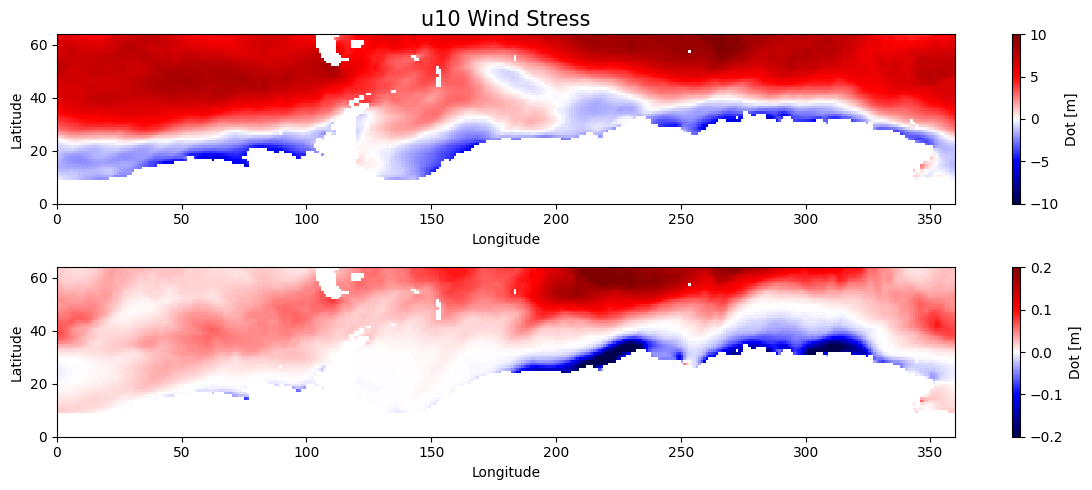

In [72]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(u10_wsc[150],cmap='seismic',vmin=-10,vmax=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('u10 Wind Stress', fontsize=15)
cbar1= plt.colorbar()
cbar1.set_label('Dot [m]')
plt.subplot(2,1,2)
plt.pcolormesh(tau_x_wsc[0],cmap='seismic',vmin=-0.2,vmax=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar2= plt.colorbar()
cbar2.set_label('Dot [m]')


plt.tight_layout()

In [73]:
# wind stress curl
ws_curl = np.zeros(tau_x_wsc.shape)
for t in range(0,dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x_wsc[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y_wsc[t], llon, llat)
    ws_curl[t] = dtauy_dx - dtaux_dy

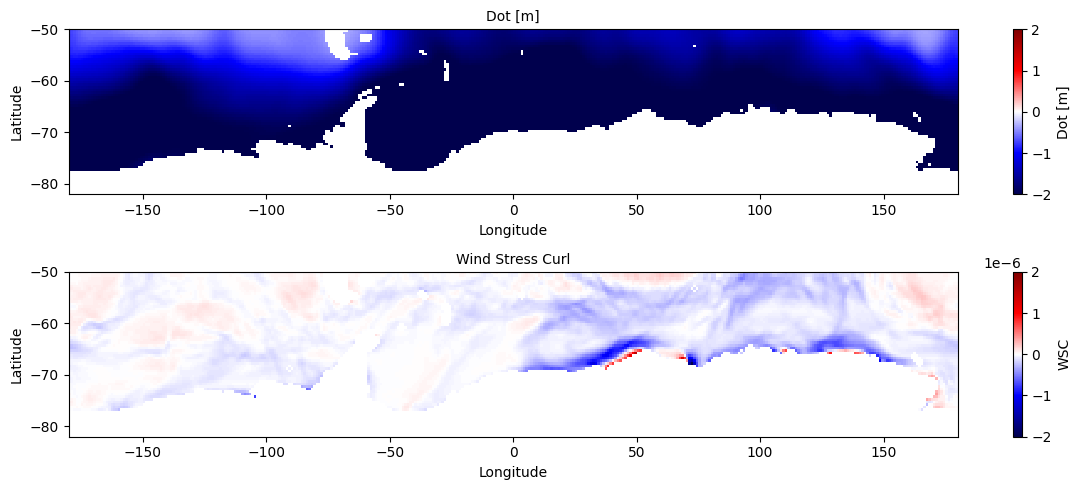

In [74]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(llon, llat, dot[0], vmin=-2, vmax=2, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dot [m]', fontsize=10)
ws1bar = plt.colorbar()
ws1bar.set_label('Dot [m]')

plt.subplot(2,1,2)
plt.pcolormesh(llon, llat, ws_curl[0], vmin=-2e-6, vmax=2e-6, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Stress Curl', fontsize=10)
#plt.quiver(llon, llat, u10[0], v10[0])
ws2bar = plt.colorbar()
ws2bar.set_label('WSC')

plt.tight_layout()

In [75]:
# linear regression in time on each grid point
n_wsc,slope_wsc,intercept_wsc,p_val_wsc,r_square_wsc,rmse_wsc = linregress_3D(ws_curl)
# remove trend for ws_curl
xt_wsc = np.zeros(ws_curl.shape)
for t in range(0,ws_curl.shape[0]):
    xt_wsc[t] = t
ws_curl_detrended = ws_curl - (slope_wsc*xt_wsc + intercept_wsc)

In [76]:
seaice_drift_u_final = seaice_drift_u_detrended.copy()
seaice_drift_v_final = seaice_drift_v_detrended.copy()

seaice_drift_masked_u_final = seaice_drift_u_detrended_masked.copy()
seaice_drift_masked_v_final = seaice_drift_v_detrended_masked.copy()

U_final = U_detrended.copy()
sid_curl_final = sid_curl_detrended.copy()

ws_curl_final = ws_curl_detrended.copy()

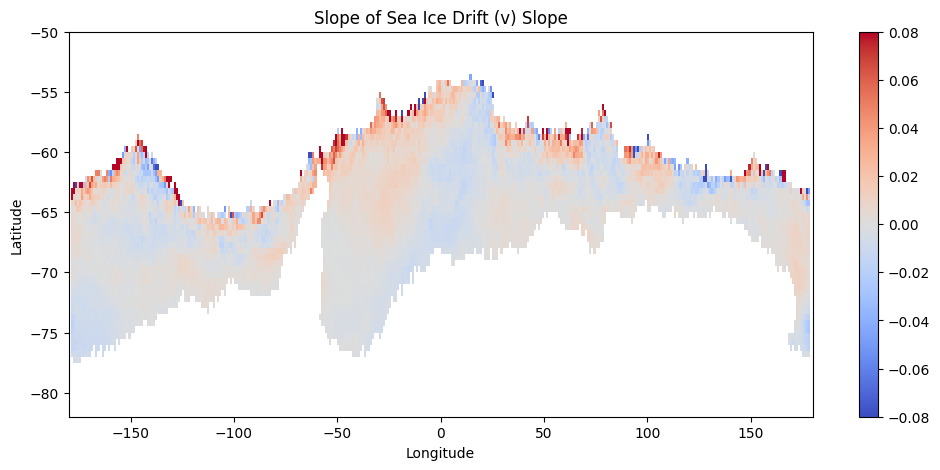

In [77]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si_v, vmin=-0.08, vmax=0.08, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Drift (v) Slope')
plt.colorbar()

In [78]:
#DESEASONAL

In [79]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1

In [80]:
# find and remove seasonality from dot_detrended and seaice_detrended and ws_curl_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]));
ws_curl_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    #seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_drift_u_detrended[np.where(months==m)], axis=0)
    ws_curl_seas[m-1] = np.nanmean(ws_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality from dot and sea ice concetration
#dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_detrended.shape)
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_drift_u_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_drift_u_detrended[i] - seaice_seas[m-1]
    ws_curl_final[i] = ws_curl_detrended[i] - ws_curl_seas[m-1]
    #seaice_final[i] = seaice_detrended[i] - seaice_seas[m-1]



In [81]:
print("dot_detrended shape:", dot_detrended.shape)
# print("seaice_detrended shape:", seaice_detrended.shape)
print("seaice_detrended shape:", seaice_drift_u_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (196, 64, 360)
seaice_detrended shape: (196, 64, 360)
months shape: (196,)


In [82]:
# find and remove seasonality from U_detrended and sid_curl_detrended
U_seas = np.zeros((12,U_ice.shape[1],U_ice.shape[2])); sid_curl_seas = np.zeros((12,sid_curl.shape[1],sid_curl.shape[2]))
for m in range(1,13):
    U_seas[m-1] = np.nanmean(U_detrended[np.where(months==m)], axis=0)
    #seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)
    sid_curl_seas[m-1] = np.nanmean(sid_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality from U and sea ice drift curl
U_final = np.zeros(U_detrended.shape); sid_curl_final = np.zeros(sid_curl_detrended.shape)
for i,m in enumerate(months):
    U_final[i] = U_detrended[i] - U_seas[m-1]
    sid_curl_final[i] = sid_curl_detrended[i] - sid_curl_seas[m-1]


In [83]:
# excract SIC from nsidc data
directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
nsidc_sic_ds = xr.open_dataset(directory+'seaice_xa_masked_nsidc.nc')
print(nsidc_sic_ds)
nsidc_sic = nsidc_sic_ds['seaice_xa_masked']

<xarray.Dataset> Size: 36MB
Dimensions:           (time: 196, lat: 64, lon: 360)
Coordinates:
  * time              (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat               (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon               (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_xa_masked  (time, lat, lon) float64 36MB ...


In [84]:
#calculate tau_ice_water and tau_air_water
tau_ice_water = ws_curl_final
tau_air_water = sid_curl_final
alpha = nsidc_sic

print('NaNs in alpha: ', alpha.isnull().sum().item())
print('NaNs in tau_ice_water: ', np.isnan(tau_ice_water).sum())
print('NaNs in tau_air_water: ', np.isnan(tau_air_water).sum())

#calculate total ocean surface stress
total_ocean_surface_stress = alpha * tau_ice_water + (1-alpha) * tau_air_water
print('osc shape', total_ocean_surface_stress.shape)
print('NaNs in osc:  ', total_ocean_surface_stress.isnull().sum().item())
print(total_ocean_surface_stress)

total_osc_masked = total_ocean_surface_stress.fillna(0)
print(total_osc_masked)
print('Nans left in osc: ', total_osc_masked.isnull().sum().item())


NaNs in alpha:  0
NaNs in tau_ice_water:  1693636
NaNs in tau_air_water:  3958599
osc shape (196, 64, 360)
NaNs in osc:   3961975
<xarray.DataArray 'seaice_xa_masked' (time: 196, lat: 64, lon: 360)> Size: 36MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [85]:
lat = ds_era5['latitude'].values
lon = ds_era5['longitude'].values
print(len(lat), len(lon))
print(ds_era5['time'])

360 64
<xarray.DataArray 'time' (time: 288)> Size: 2kB
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2023-12-01
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T


In [86]:
print(tau_x_wsc)

[[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02068101 0.01995691 0.01893414 ... 0.02478185 0.02406133 0.02285532]
  [0.02073882 0.02002566 0.01897176 ... 0.02542477 0.02491941 0.02391698]
  [0.02081135 0.01977531 0.01851727 ... 0.02508504 0.02510456 0.0242639 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02263992 0.02283532 0.02308318 ... 0.0202767  0.02100487 0.02146125]
  [0.01919219 0.01941123 0.01973684 ... 0.01726765 0.01758919 0.01786926]
  [0.01712514 0.01781618 0.01820304 ... 0.01602753 0.01570514 0.01575291]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        n

In [87]:
#create xarray for tau_wsc for x and y and tau_ice_water and tau_air_water
time_steps = 196
lat_points = 64
lon_points = 360

#start_time = '2000-01-01T00:00:00.000000000'
time = ds_era5['time'][tstart_era5:tend_era5].values

lat = ds_era5['latitude'].values
lon = ds_era5['longitude'].values

tau_ds = xr.Dataset(
    {
        'tau_x_wsc': (['time', 'lon', 'lat'], tau_x_wsc),
        'tau_y_wsc': (['time', 'lon', 'lat'], tau_y_wsc),
        'tau_x_sid': (['time', 'lon', 'lat'], tau_x_sid.values),
        'tau_y_sid': (['time', 'lon', 'lat'], tau_y_sid.values),
        'tau_ice_water': (['time', 'lon', 'lat'], tau_ice_water),
        'tau_air_water': (['time', 'lon', 'lat'], tau_air_water),
    },
    coords={'time': time, 'lat': lat, 'lon': lon},
)

print(tau_ds)



<xarray.Dataset> Size: 217MB
Dimensions:        (time: 196, lon: 64, lat: 360)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat            (lat) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lon            (lon) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
Data variables:
    tau_x_wsc      (time, lon, lat) float64 36MB nan nan nan ... 0.1312 0.1307
    tau_y_wsc      (time, lon, lat) float64 36MB nan nan ... 0.007305 0.01033
    tau_x_sid      (time, lon, lat) float64 36MB nan nan nan nan ... nan nan nan
    tau_y_sid      (time, lon, lat) float64 36MB nan nan nan nan ... nan nan nan
    tau_ice_water  (time, lon, lat) float64 36MB nan nan ... 1.079e-07 1.101e-07
    tau_air_water  (time, lon, lat) float64 36MB nan nan nan nan ... nan nan nan


In [89]:
directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
tau_ds.to_netcdf(directory+'tau_eumetsat_ds2.nc')
sid_curl_xa_masked.to_netcdf(directory+'sidc_eumetsat_masked.nc')
WSC_xa_masked.to_netcdf(directory+'WSC_eumetsat_masked.nc')

NameError: name 'sid_curl_xa_masked' is not defined

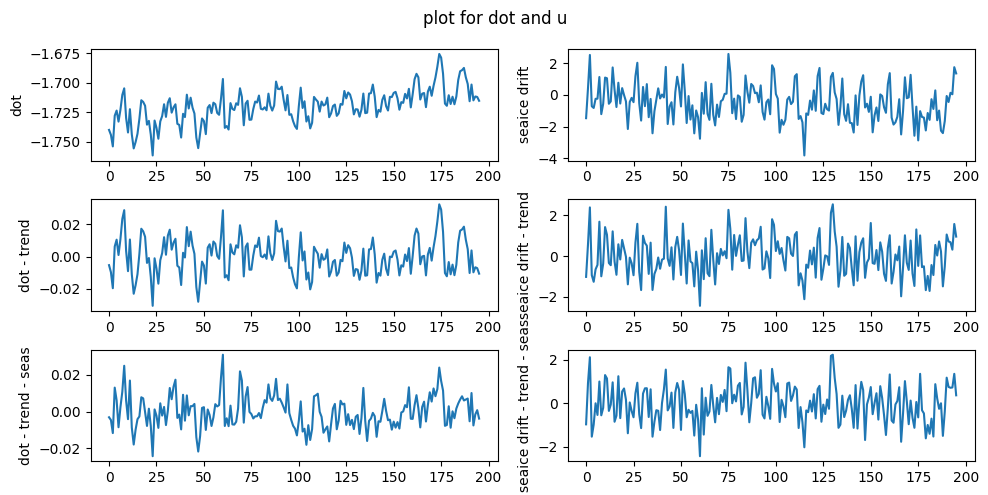

In [91]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(regridded_seaice_ds['seaice_drift_u'], axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(seaice_drift_u_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and u" )

plt.tight_layout()

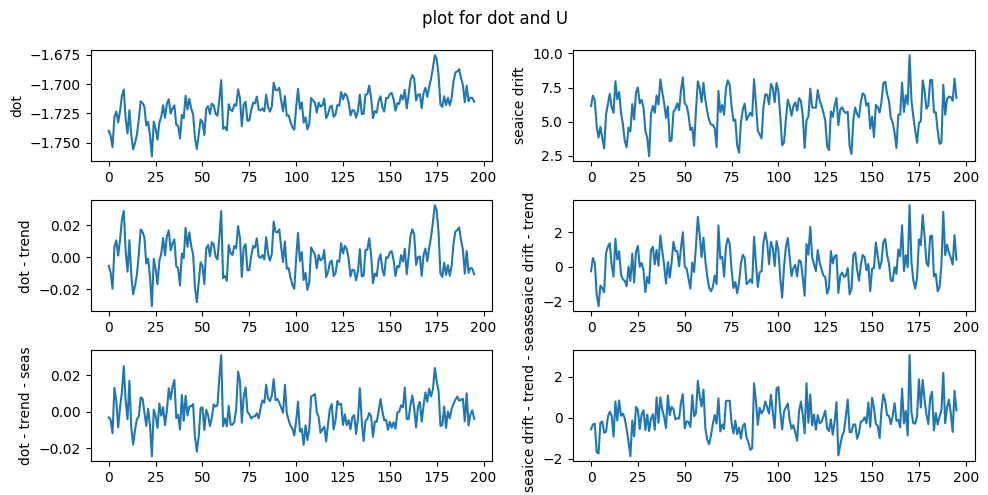

In [92]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(U_ice, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(U_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(U_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and U" )

plt.tight_layout()

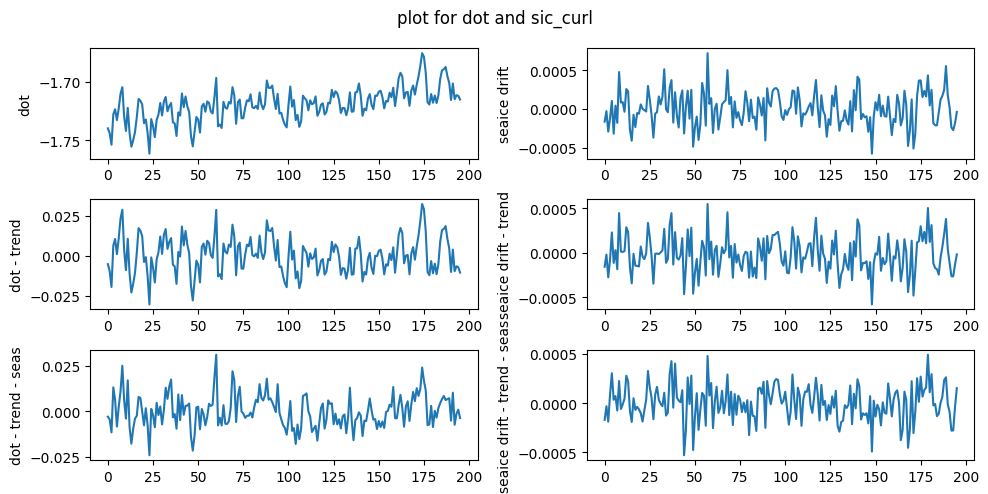

In [93]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(sid_curl, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(sid_curl_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(sid_curl_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and sic_curl" )
plt.tight_layout()


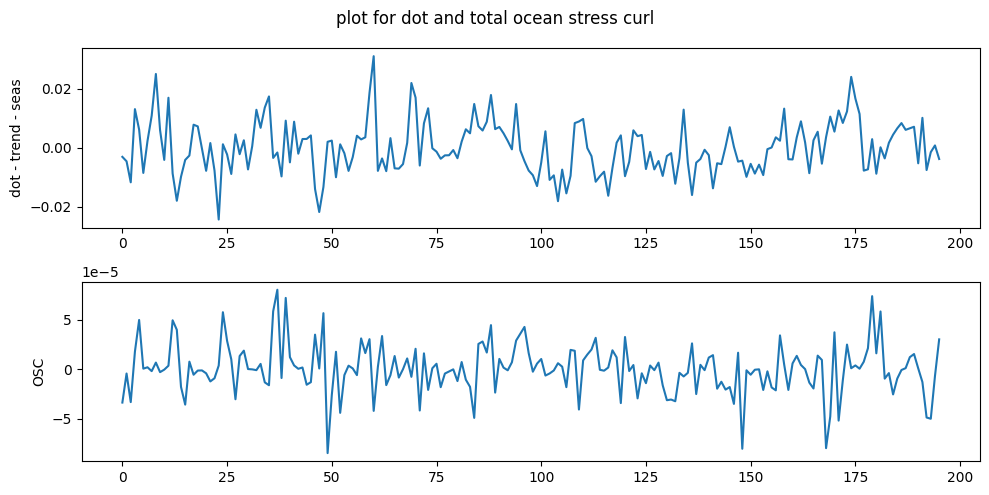

In [94]:

fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(2,1,2)
#plt.plot(np.nanmean(total_ocean_surface_stress, axis=(1,2)))
plt.plot(np.nanmean(total_osc_masked, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('OSC')
plt.suptitle(f"plot for dot and total ocean stress curl" )
plt.tight_layout()

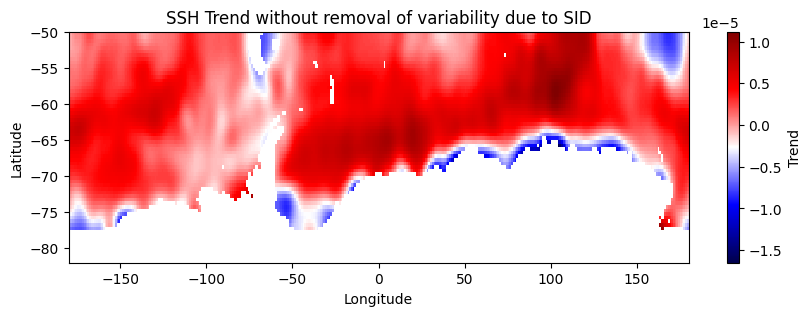

In [95]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SID')
cbar = plt.colorbar()
cbar.set_label('Trend')

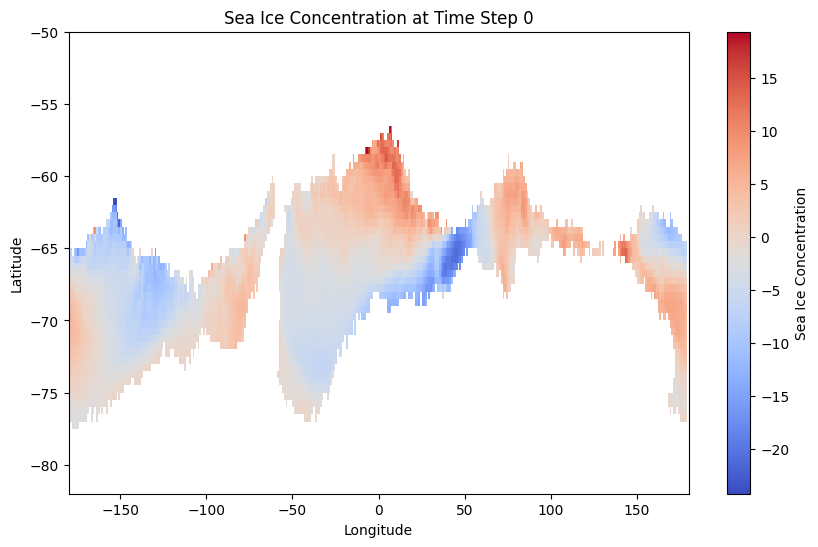

In [96]:
time_step = 0  #  can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_ds['seaice_drift_u'].isel(time = time_step)


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [97]:
# MCA

In [98]:
#MCA of dot, seaice conc, U, sea ice drift, WSC

dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
U_xa = xr.DataArray(U_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
sid_curl_xa = xr.DataArray(sid_curl_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
ws_curl_xa = xr.DataArray(ws_curl_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)


min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -25.794540929070024, Max = 26.673503384432898


In [99]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1582308
Total NaN values in seaice_xa: 3756154
Total data points in dot_xa: 4515840
Total data points in seaice_xa: 4515840
(196, 64, 360)
(196, 64, 360)


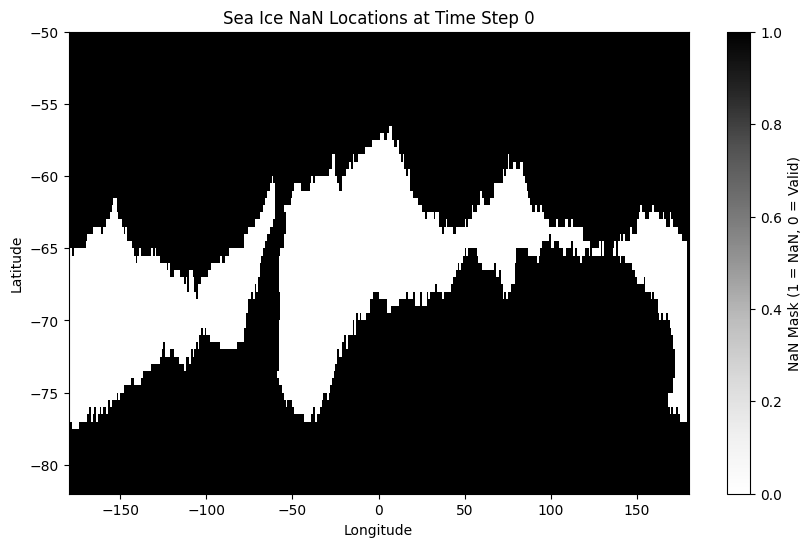

In [100]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
# seaice_nan_mask = np.isnan(regridded_seaice_filtered[time_step])
seaice_nan_mask = np.isnan(regridded_seaice_ds['seaice_drift_u'].isel(time =time_step))

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [101]:
print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [102]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)
sid_curl_xa_masked = sid_curl_xa.fillna(0)
U_xa_masked = U_xa.fillna(0)
WSC_xa_masked = ws_curl_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)

Masked dot_xa shape: (196, 64, 360)
Masked seaice_xa shape: (196, 64, 360)


In [103]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [104]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [105]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [106]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [107]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [108]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [109]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_test_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [110]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [111]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

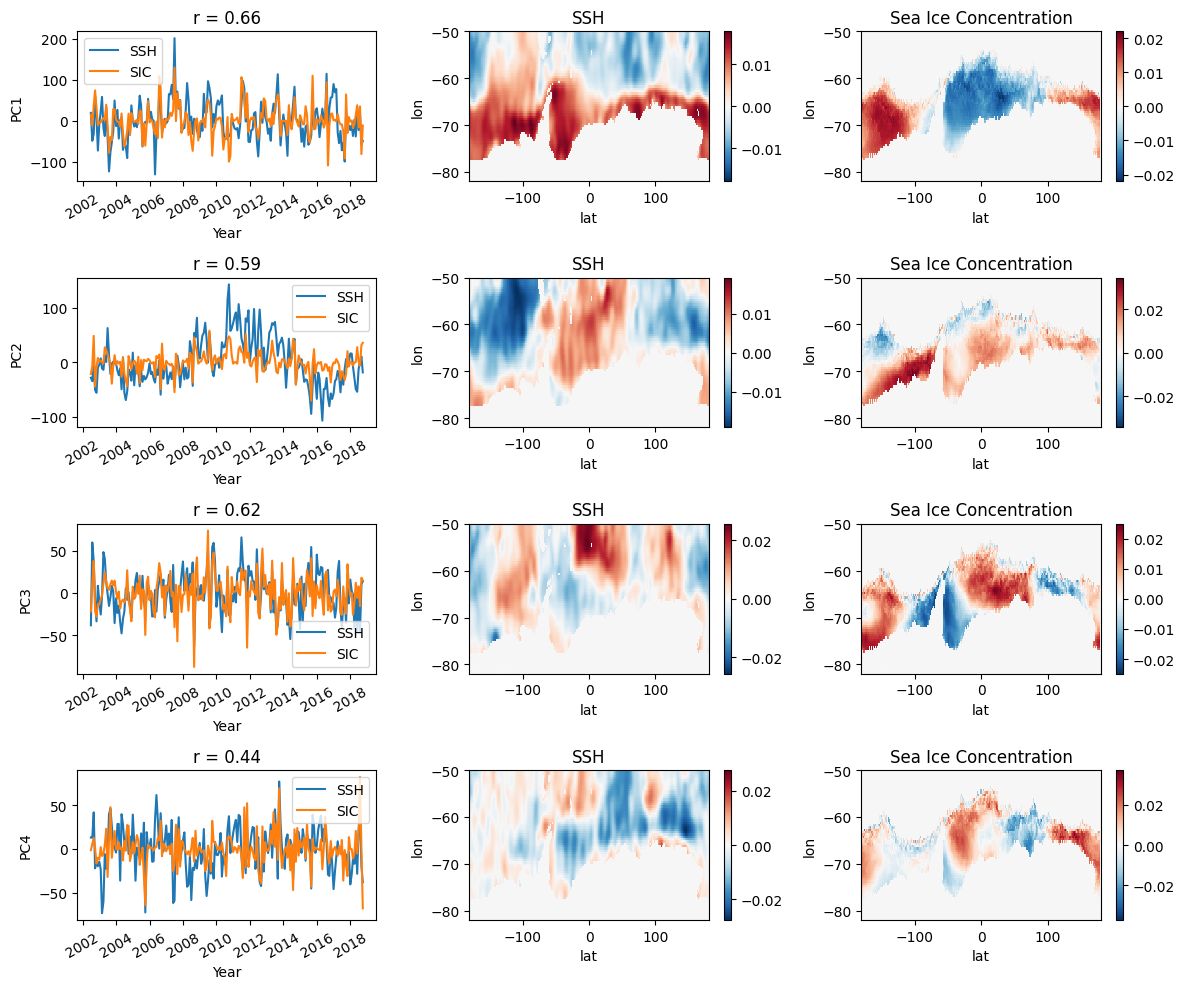

In [112]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [113]:
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.67729721 0.79728681 0.85743925 0.88589471 0.91093475 0.93097811
 0.9436288  0.95178915 0.95858614 0.9645872  0.96882224 0.97241491
 0.97569051 0.9784684  0.98103446 0.98337162 0.9850836  0.98647646
 0.98783233 0.98898088 0.99003474 0.99100644]
Squared covariance fraction: [0.67729721 0.1199896  0.06015244 0.02845546 0.02504004 0.02004335
 0.01265069 0.00816035 0.00679699 0.00600107 0.00423504 0.00359268
 0.00327559 0.00277789 0.00256606 0.00233716 0.00171198 0.00139286
 0.00135588 0.00114854 0.00105387 0.0009717 ]


In [114]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.677297212377239, 0.11998959959052913, 0.06015244162917921, 0.02845545861710963, 0.025040042434394727, 0.020043351683415644, 0.01265069491726456, 0.008160346211267266, 0.006796988704540263, 0.006001066960010792, 0.004235036109471069, 0.0035926756419044636, 0.0032755925711410727, 0.0027778891793827087, 0.00256605971982804, 0.0023371601572872436, 0.0017119837095863621, 0.001392856302319334, 0.0013558774007854657, 0.0011485429524493718, 0.0010538677789234674, 0.0009716994740516238]


In [121]:
# print(total_osc_masked)
total_osc_masked.name = 'OSC'
print(total_osc_masked)

#NEED TO ADD NAME TO THIS VARIABLE AND ALSO SAVE IT

directory = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
total_osc_masked.to_netcdf(directory+'OSC_eumetsat_ds.nc')

<xarray.DataArray 'OSC' (time: 196, lat: 64, lon: 360)> Size: 36MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],


#HERE I REPEAT THE MCA ANALYSIS FOR U AND OSC !!! - working on adapting for NaNs in OSC


Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.43611971 0.55689376 0.65467349 0.70474545 0.74804064 0.77866315
 0.805178   0.82901574 0.85127548 0.86976529 0.8860483  0.89865261
 0.90864503 0.91846492 0.9258975  0.93268516 0.93849607 0.94389394
 0.94912269 0.95369392 0.95805097 0.96223806]
Squared covariance fraction: [0.43611971 0.12077405 0.09777973 0.05007196 0.04329519 0.03062251
 0.02651485 0.02383774 0.02225974 0.01848981 0.01628301 0

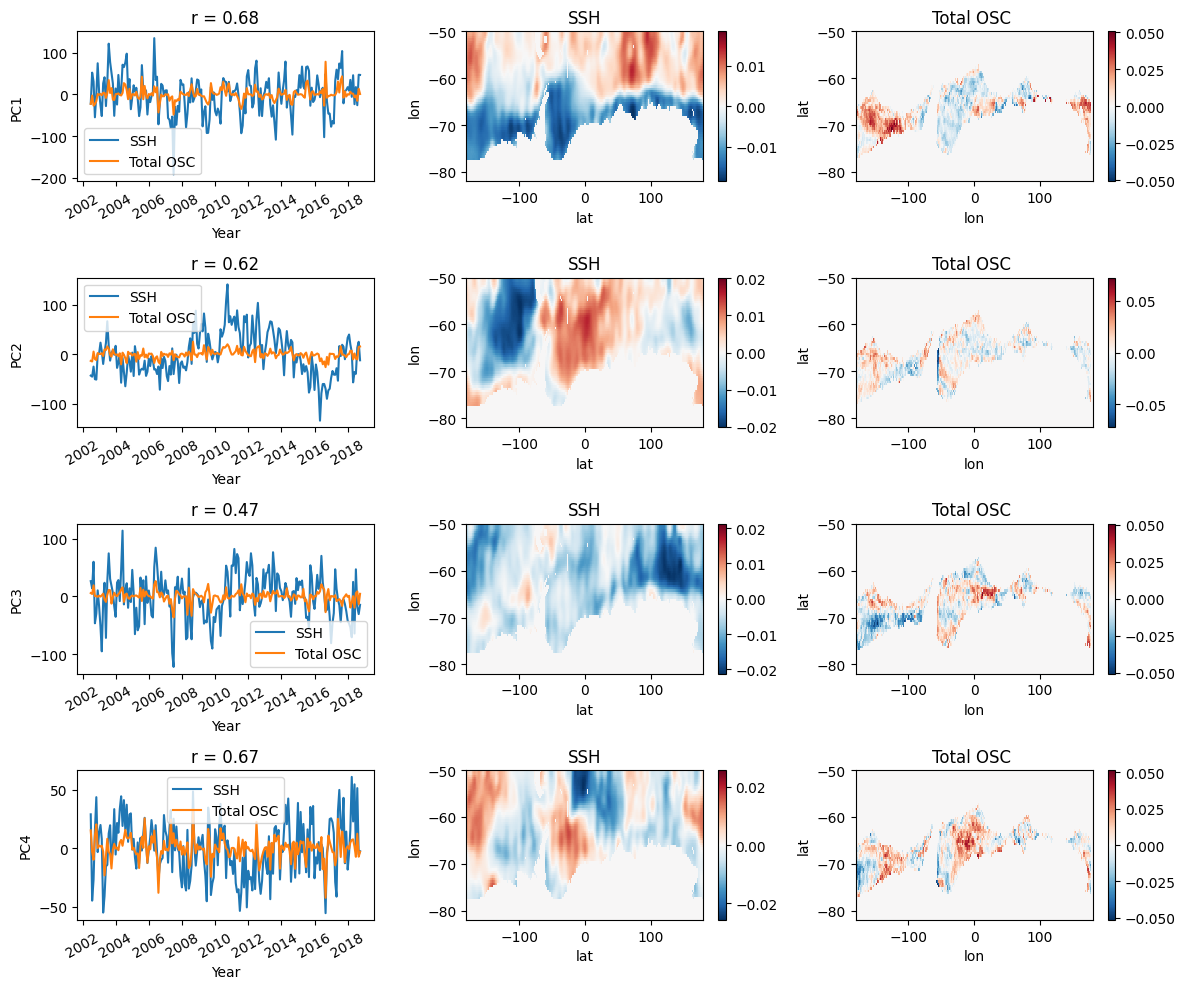

In [493]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(total_ocean_surface_stress.coords)

model.fit(dot_xa_masked, total_osc_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_total_osc' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='Total OSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Total OSC ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [494]:
#HERE I REPEAT THE MCA ANALYSIS FOR U AND SID_CURL !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.59333447 0.73800038 0.79235844 0.84117024 0.86815207 0.89287813
 0.91051276 0.92589427 0.93735617 0.94780348 0.95554396 0.96202978
 0.96635935 0.96994326 0.97313269 0.97595425 0.97867839 0.98084543
 0.98277062 0.98449697 0.98619062 0.98758809]
Squared covariance fraction: [0.59333447 0.14466591 0.05435806 0.04881179 0.02698183 0.02472606
 0.01763463 0.01538151 0.0114619  0.01044732 0.00774048 0

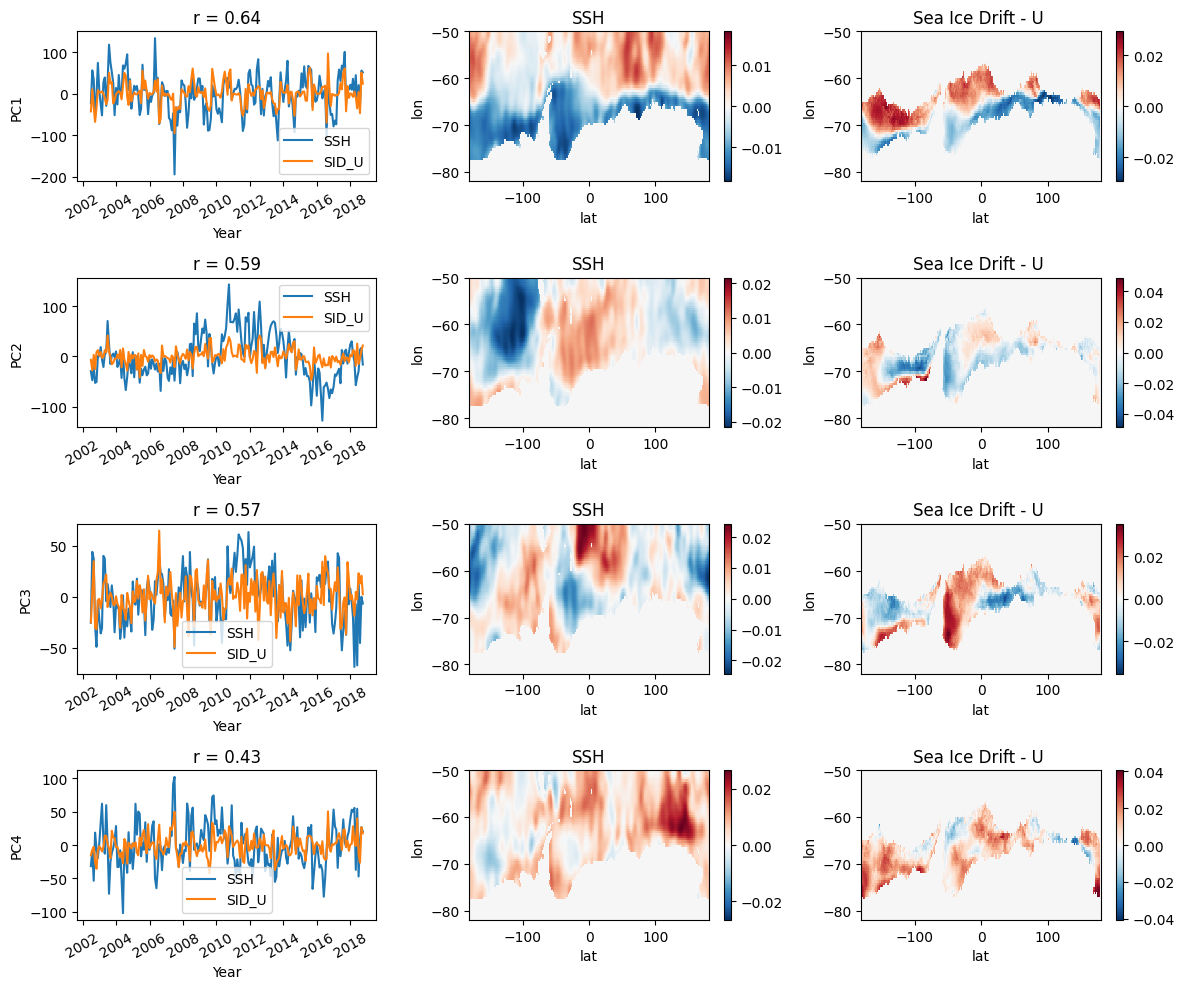

In [495]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(dot_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift - U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


In [496]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs dot !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.44618858 0.56683756 0.66053035 0.70913533 0.75197872 0.782335
 0.81014222 0.83371599 0.85476646 0.87188104 0.88836273 0.90080541
 0.91071582 0.91971129 0.92714963 0.93420097 0.93999845 0.94568685
 0.95067456 0.95506502 0.95930168 0.96339717]
Squared covariance fraction: [0.44618858 0.12064898 0.09369279 0.04860499 0.04284338 0.03035629
 0.02780722 0.02357377 0.02105047 0.01711458 0.01648169 0.0

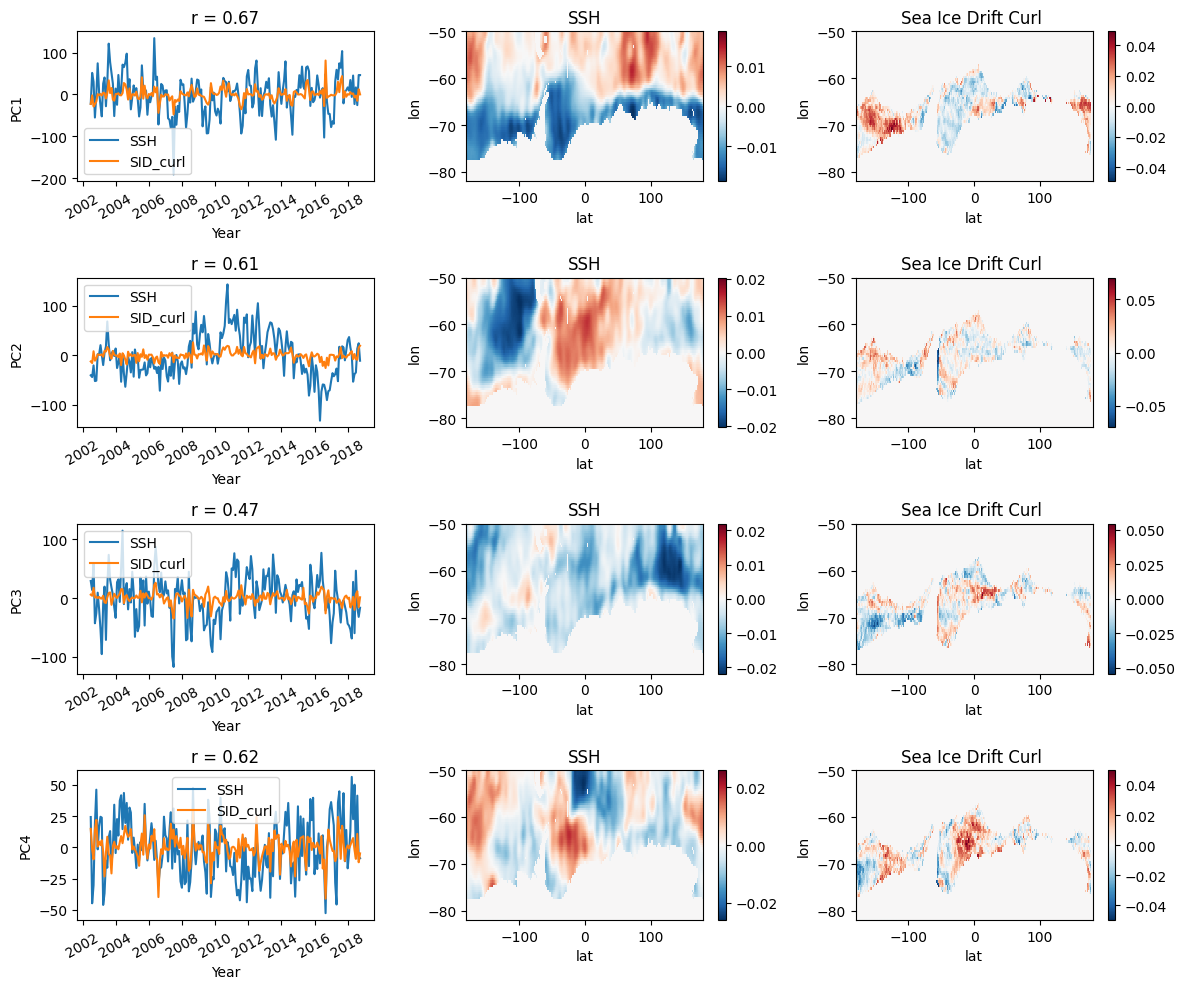

In [497]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(dot_xa_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [498]:
#SSH vs WSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.47477553 0.66575823 0.73847135 0.79474788 0.83960764 0.87224082
 0.89512479 0.91338727 0.92655207 0.93884389 0.9477588  0.95465298
 0.95950118 0.9640154  0.96824915 0.97160322 0.97446614 0.97687355
 0.97921939 0.98128297 0.98317385 0.98474773]
Squared covariance fraction: [0.47477553 0.1909827  0.07271312 0.05627653 0.04485976 0.03263319
 0.02288397 0.01826248 0.01316479 0.01229183 0.00891491 0

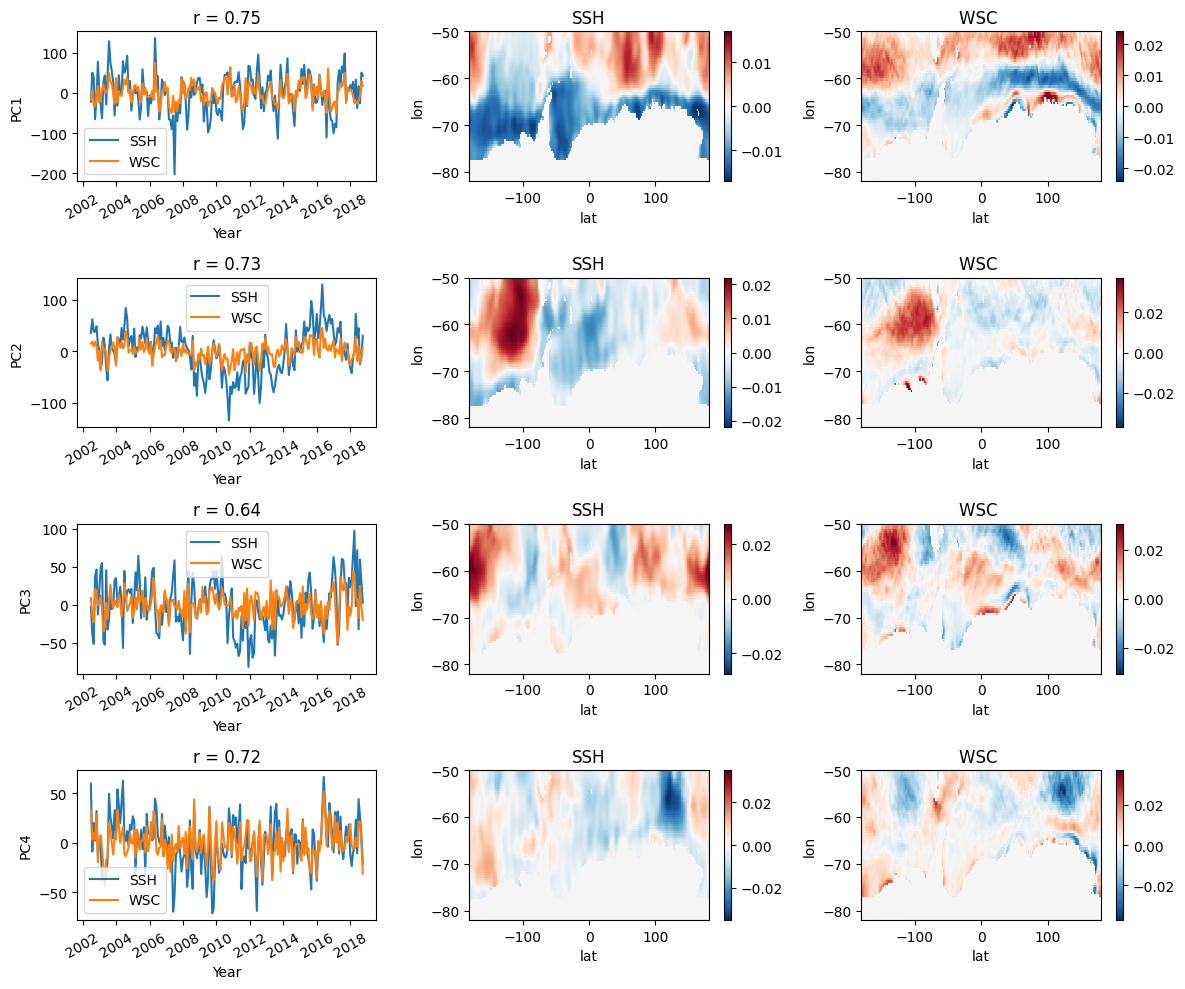

In [499]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(WSC_xa_masked.coords)

model.fit(dot_xa_masked, WSC_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='WSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('WSC ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [500]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs SIC !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.55097469 0.65720364 0.73709211 0.78678319 0.82047252 0.84973016
 0.87567657 0.88929342 0.90260572 0.91382086 0.92375677 0.93194749
 0.93872642 0.94486107 0.94991642 0.95452207 0.95874971 0.962776
 0.96654432 0.96985168 0.97293611 0.97548894]
Squared covariance fraction: [0.55097469 0.10622895 0.07988847 0.04969108 0.03368933 0.02925764
 0.02594641 0.01361684 0.01331231 0.01121514 0.00993591 0.0

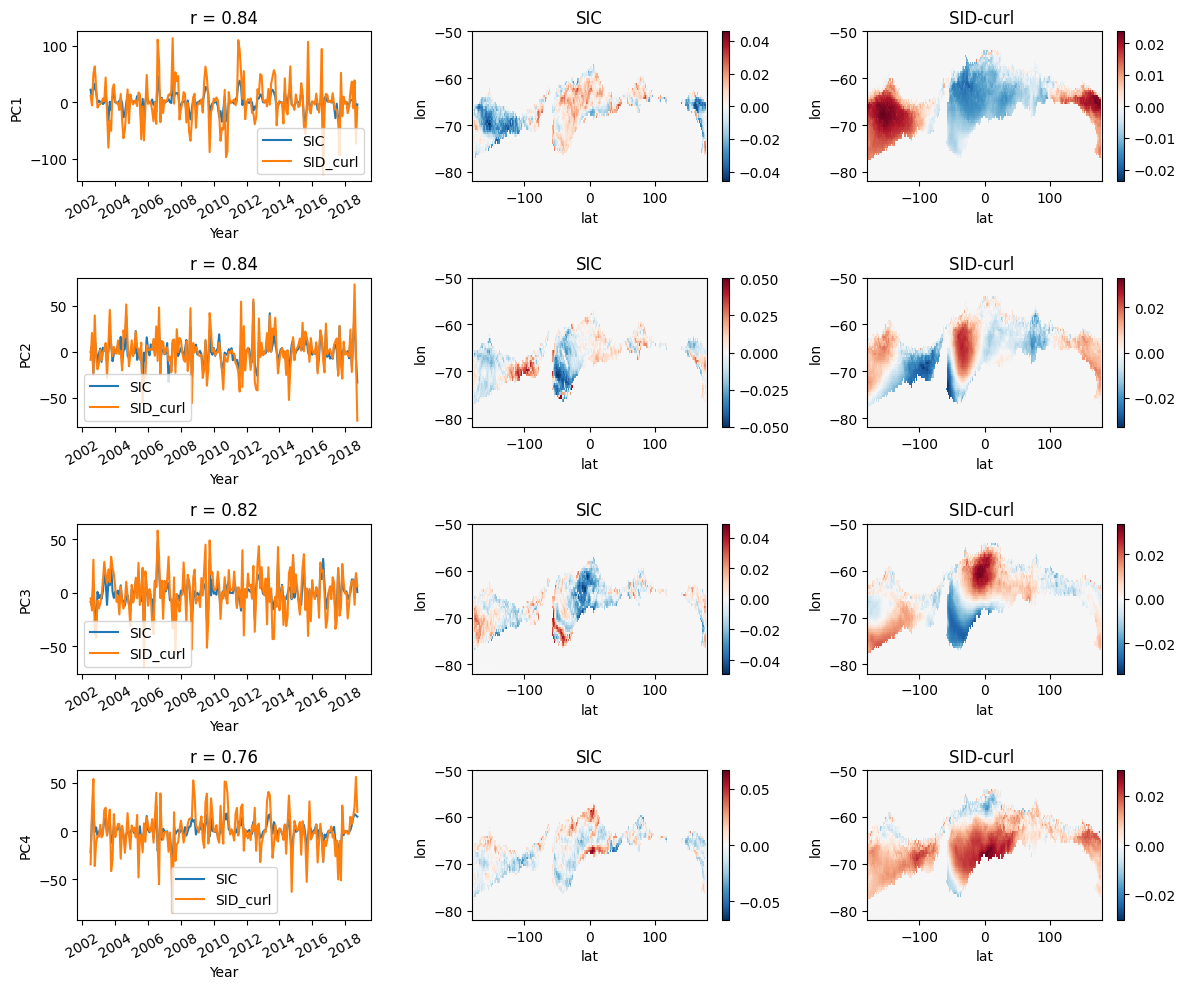

In [501]:
import inspect

model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(sid_curl_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_sic_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('SID-curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [502]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.48609723 0.59307483 0.67630614 0.72648861 0.76867436 0.79433582
 0.81823098 0.83792336 0.85439404 0.87030281 0.88489009 0.89694868
 0.90756407 0.9172562  0.92493697 0.93199434 0.93822669 0.94410269
 0.94907434 0.95351938 0.95751338 0.96133599]
Squared covariance fraction: [0.48609723 0.1069776  0.08323131 0.05018247 0.04218575 0.02566146
 0.02389516 0.01969237 0.01647069 0.01590876 0.01458729 0

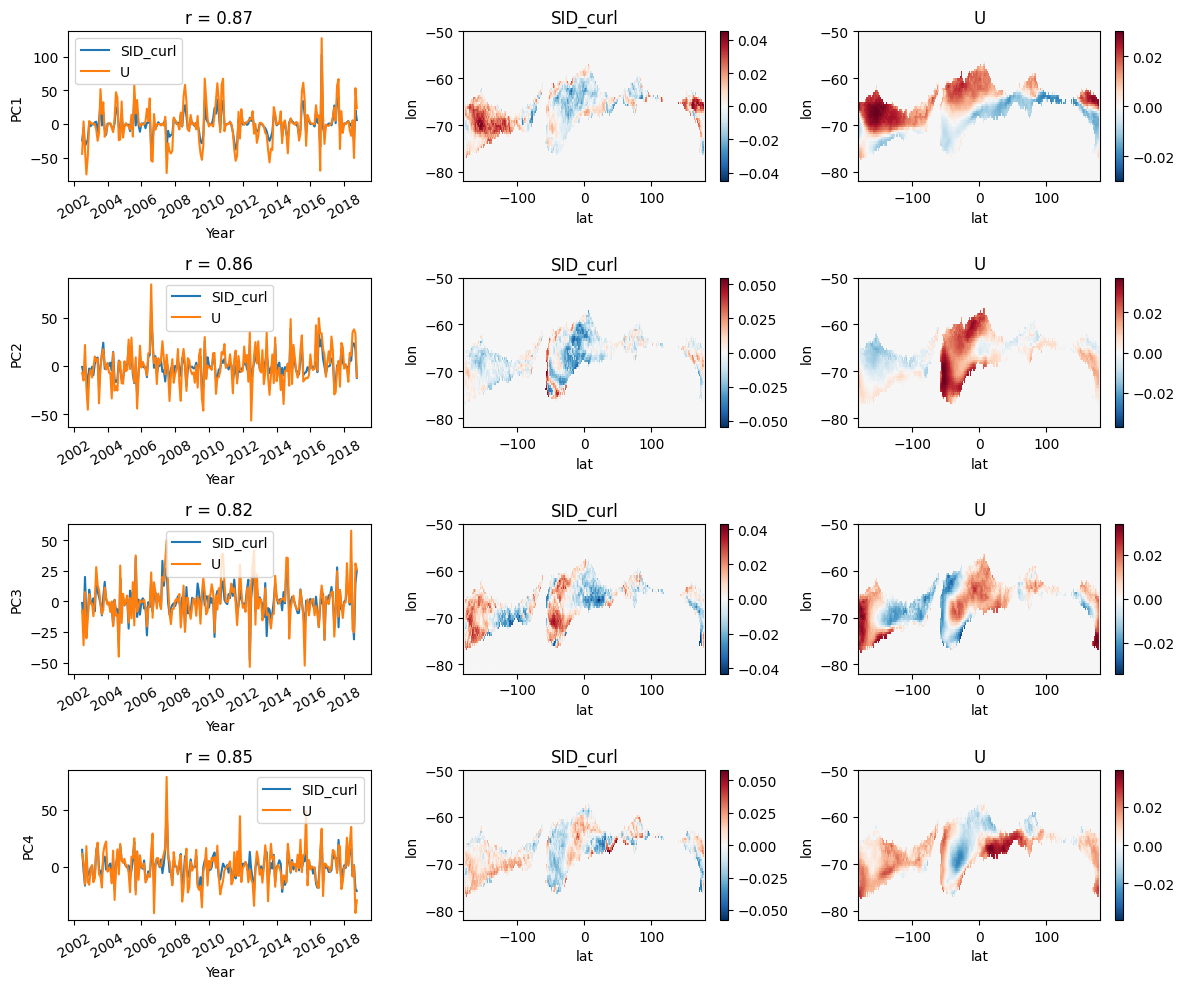

In [503]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(sid_curl_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_U_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SID_curl')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SID_curl')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [504]:
#HERE I REPEAT THE MCA ANALYSIS FOR SIC vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.6794434  0.77398286 0.8337671  0.87594275 0.91058799 0.9246079
 0.93633565 0.94600352 0.95361061 0.96041686 0.96533167 0.97012037
 0.97375429 0.97671118 0.97907932 0.98130049 0.98317246 0.98493535
 0.98646637 0.98770185 0.98882456 0.98985772]
Squared covariance fraction: [0.6794434  0.09453946 0.05978424 0.04217565 0.03464525 0.01401991
 0.01172775 0.00966787 0.00760709 0.00680624 0.00491481 0.

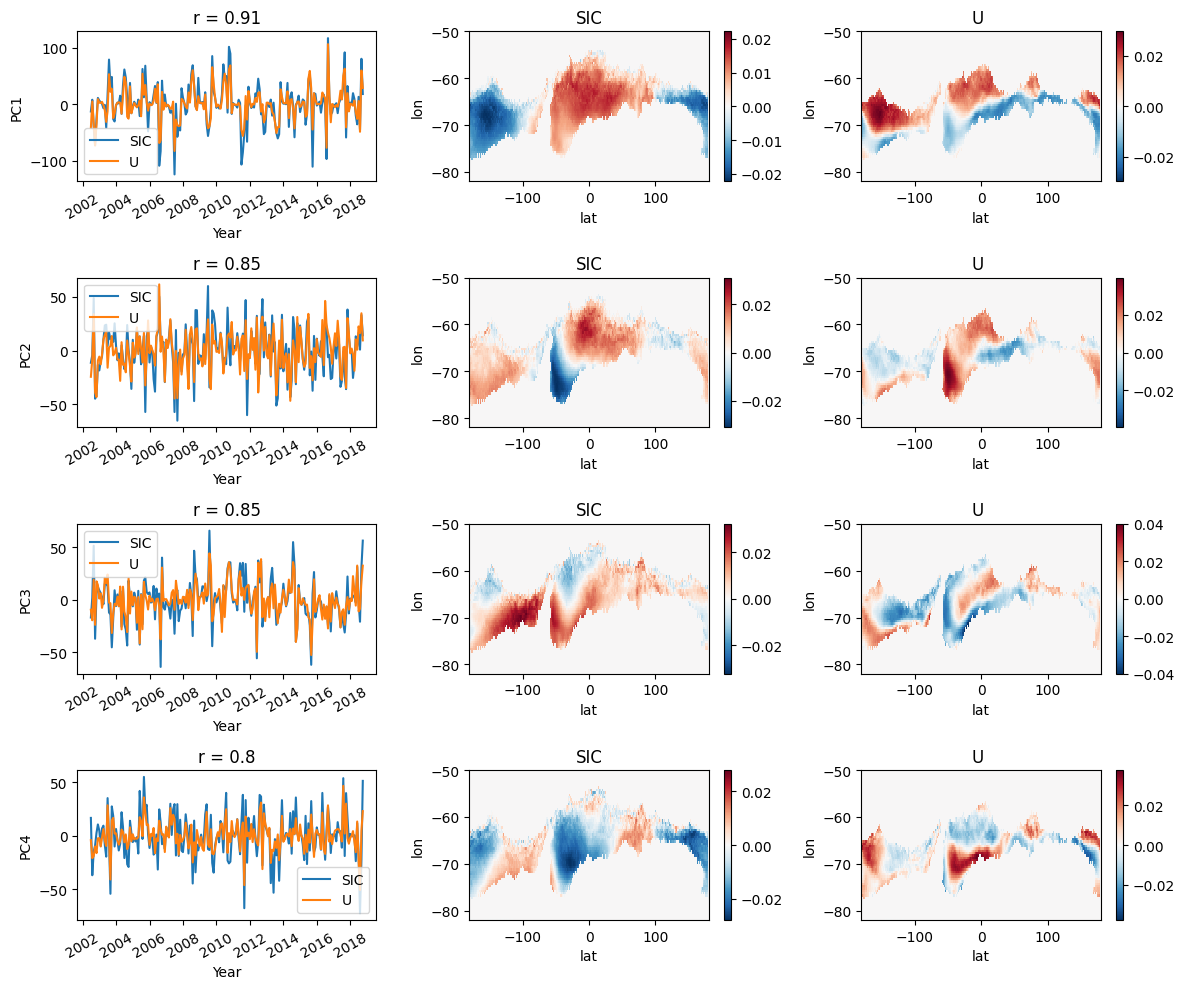

In [505]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(seaice_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(seaice_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [506]:
#WSC and OSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.38007362 0.46634521 0.53554943 0.5976995  0.63783742 0.67504482
 0.70970556 0.74046345 0.7670086  0.78765787 0.80749296 0.8258636
 0.84034911 0.85388988 0.86519172 0.87632749 0.88604831 0.89531547
 0.90381449 0.91118044 0.91816817 0.92472627]
Squared covariance fraction: [0.38007362 0.08627159 0.06920422 0.06215007 0.04013792 0.0372074
 0.03466074 0.0307579  0.02654515 0.02064927 0.01983509 0.0

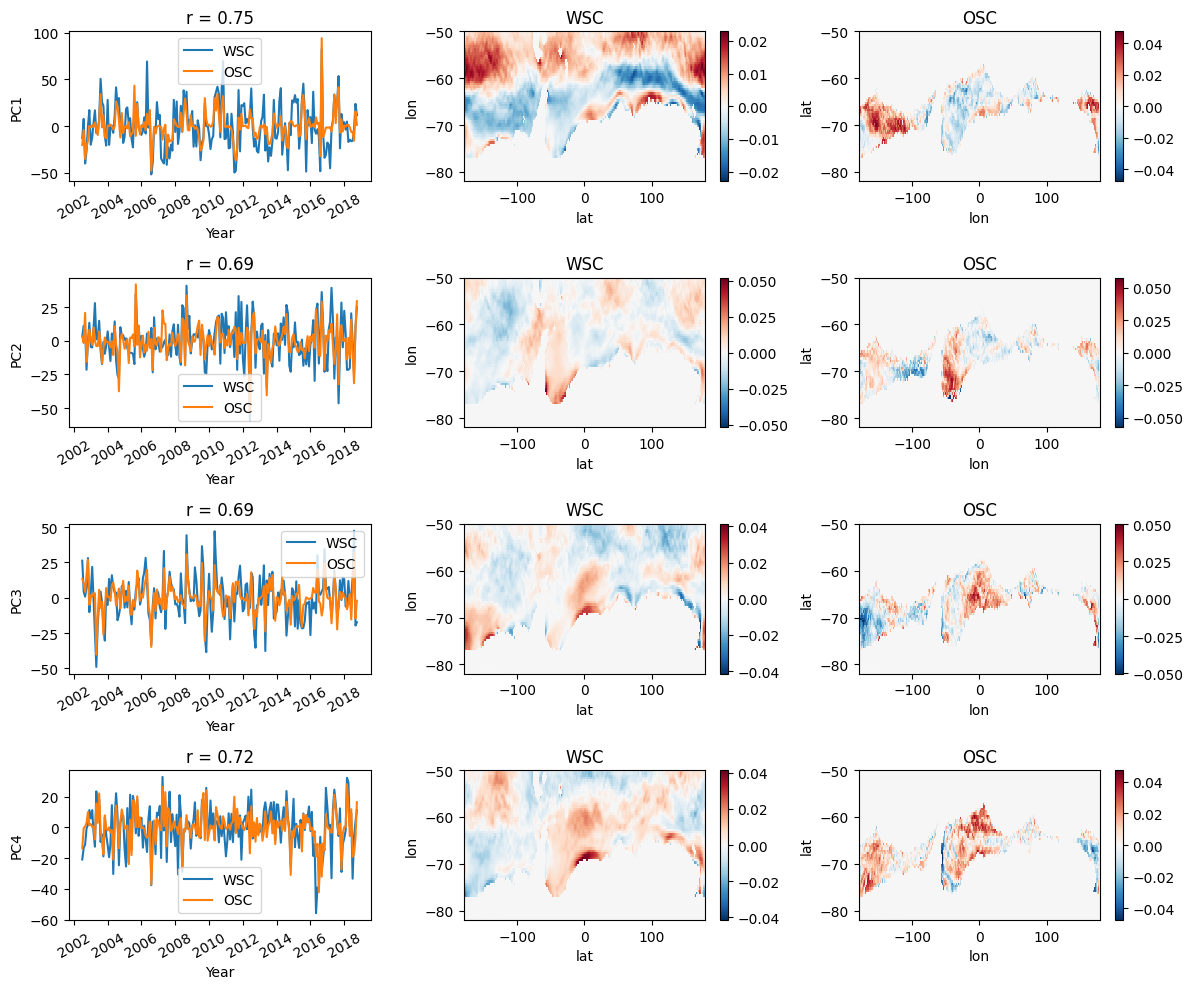

In [507]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(WSC_xa_masked.coords)
print(total_osc_masked.coords)

model.fit(WSC_xa_masked, total_osc_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='WSC')
    scores2.sel(mode=i + 1).plot(label='OSC')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('WSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('OSC')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [508]:
#OSC and SID_C

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lat      (lat) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.27923902 0.4027935  0.48266941 0.53009195 0.57045562 0.6091166
 0.63969639 0.66572303 0.68902448 0.70772107 0.72579937 0.74259204
 0.75847107 0.77331206 0.78615819 0.798121   0.80955482 0.82039023
 0.83058549 0.84011104 0.84912993 0.85767164]
Squared covariance fraction: [0.27923902 0.12355449 0.0798759  0.04742254 0.04036367 0.03866098
 0.03057979 0.02602664 0.02330145 0.01869659 0.0180783  0.

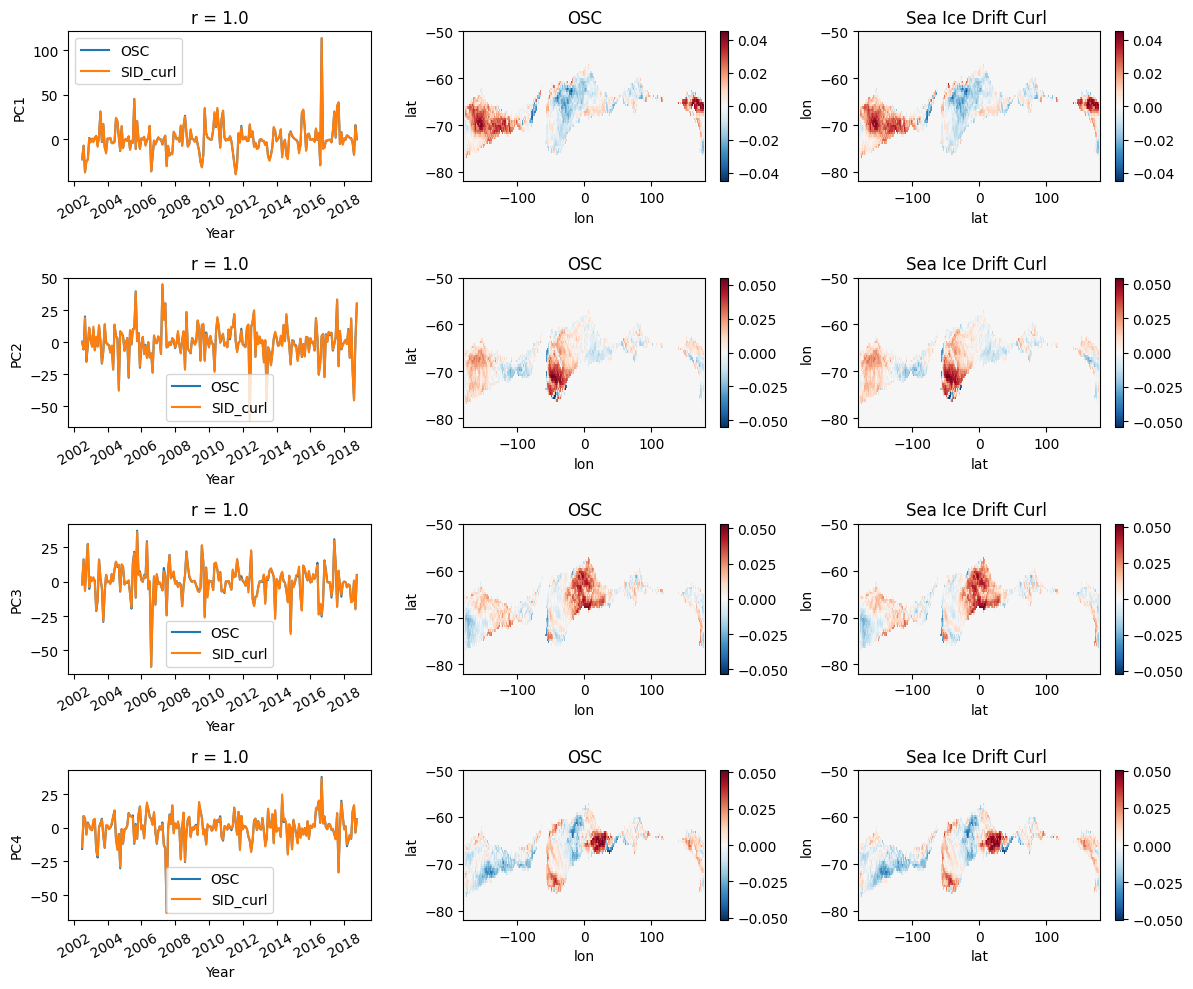

In [509]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(total_osc_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(total_osc_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='OSC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('OSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [510]:
#SID_C and WSC

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.38754954 0.47504026 0.54311632 0.60472953 0.64535322 0.68136006
 0.71499024 0.74587086 0.77302254 0.79427567 0.81421897 0.8314058
 0.84587974 0.85934429 0.87005977 0.88026219 0.88971182 0.89878069
 0.9071679  0.9142331  0.92076709 0.92690939]
Squared covariance fraction: [0.38754954 0.08749072 0.06807606 0.06161321 0.04062369 0.03600684
 0.03363018 0.03088062 0.02715168 0.02125313 0.0199433  0.

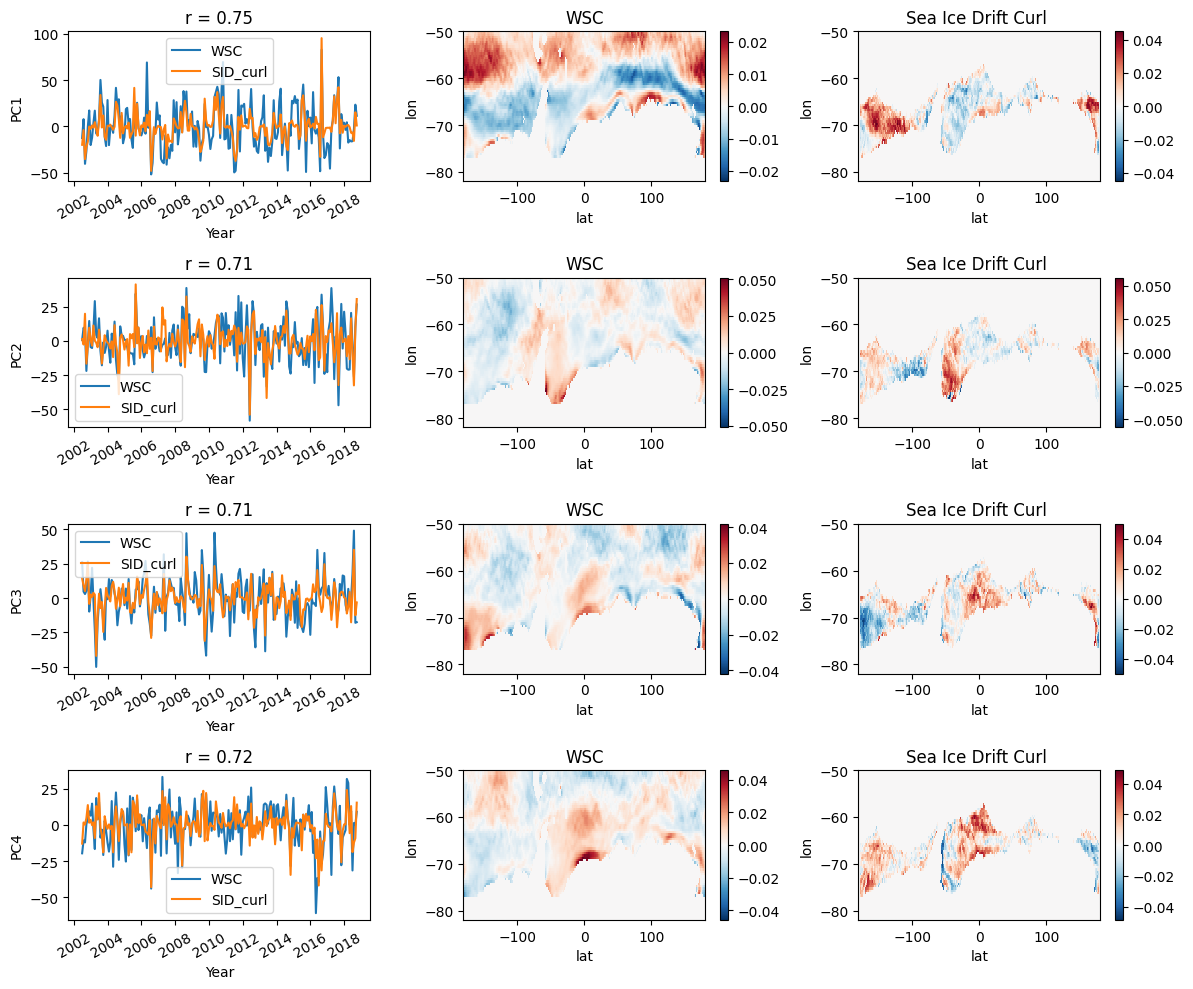

In [511]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(WSC_xa_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(WSC_xa_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='WSC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('WSC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [512]:
# 1st SVD PCA modes of time series and SAM index (monthly and seas) for SSH, WSC, OCS

In [513]:
monthly_sam = ds_monthly_sam['SAM']
print(monthly_sam)
monthly_time = ds_monthly_sam['time'].values
print(len(monthly_time))

monthly_sam_start_date = 546
monthly_sam_end_date = 741
print(monthly_sam_start_date)
print(monthly_sam_end_date)

filtered_monthly_sam = monthly_sam[monthly_sam_start_date:monthly_sam_end_date + 1]

# Compute mean and standard deviation
f_monthly_sam_mean = filtered_monthly_sam.mean()
f_monthly_sam_std = filtered_monthly_sam.std()

# Normalize SAM
normalized_monthly_sam = (filtered_monthly_sam - f_monthly_sam_mean) / f_monthly_sam_std
print(normalized_monthly_sam.values)



<xarray.DataArray 'SAM' (time: 828)> Size: 7kB
[828 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 7kB 1957-01-01T12:00:00 ... 2025-12-01T12:...
828
546
741
[-6.98651800e-01  4.07097531e-01 -1.62112776e+00 -3.81429909e+00
 -2.71013937e-01  4.98734216e-01 -6.07015116e-01 -8.88034283e-01
 -3.32105061e-01  1.06077255e+00  3.46006408e-01 -1.82883758e+00
  4.43752205e-01  1.13408190e+00 -8.94143395e-01 -2.16031926e-01
 -3.80977959e-01 -7.10870025e-01  1.27459148e+00 -2.32367568e+00
  1.62733038e-01  4.43752205e-01 -3.80977959e-01  7.43098710e-01
  1.25015503e+00 -2.89341274e-01  7.91971608e-01 -6.49778902e-01
 -1.01021653e+00 -9.12470732e-01  3.64333745e-01  6.82007586e-01
 -3.62650622e-01  1.82441159e+00 -5.64251329e-01 -5.39814880e-01
 -5.94796891e-01  1.61143422e-02 -5.10858934e-02 -3.56541510e-01
  1.13860140e-01 -1.97545628e+00  5.27690162e-02 -1.41952706e+00
  7.24771373e-01 -7.10870025e-01  1.10353634e+00  9.63026753e-01
  6.94225811e-01 -1.90214693e+00 -4

In [514]:
ann_sam = ds_seas_sam['ANN_sam']
print(ann_sam)
ann_time = ds_seas_sam['ANN_time'].values
print(len(ann_time))

ann_sam_start_date = 50
ann_sam_end_date = 61
print(ann_sam_start_date)
print(ann_sam_end_date)

filtered_ann_sam = ann_sam[ann_sam_start_date:ann_sam_end_date + 1]


# Compute mean and standard deviation
f_ann_sam_mean = filtered_ann_sam.mean()
f_ann_sam_std = filtered_ann_sam.std()

# Normalize SAM
normalized_ann_sam = (filtered_ann_sam - f_ann_sam_mean) / f_ann_sam_std
print(normalized_ann_sam.values)


<xarray.DataArray 'ANN_sam' (year: 68)> Size: 544B
[68 values with dtype=float64]
Coordinates:
  * year      (year) int64 544B 1957 1958 1959 1960 1961 ... 2021 2022 2023 2024
    ANN_time  (year) datetime64[ns] 544B ...
    AUT_time  (year) datetime64[ns] 544B ...
    WIN_time  (year) datetime64[ns] 544B ...
    SPR_time  (year) datetime64[ns] 544B ...
    SUM_time  (year) datetime64[ns] 544B ...
68
50
61
[-1.81822576  0.54243628 -1.05197809  1.31642383 -0.61080518  0.41085839
 -0.99005908 -0.20833165  1.97431325  0.07030387  0.07030387  0.29476026]


In [515]:
# Define a function to normalize SAM data for each season
def normalize_seasonal_sam(season_sam, season_time, start_date, end_date):
    filtered_season_sam = season_sam[start_date:end_date + 1]

    # Compute mean and standard deviation
    season_sam_mean = filtered_season_sam.mean()
    season_sam_std = filtered_season_sam.std()

    # Normalize SAM
    normalized_season_sam = (filtered_season_sam - season_sam_mean) / season_sam_std
    return normalized_season_sam

# Define the start and end dates for each season
season_dates = {
    "SPR": (45, 61),  # Spring start and end dates
    "WIN": (45, 61),  # Annual start and end dates
    "SUM": (45, 61),  # Summer start and end dates
    "AUT": (46, 61)   # Autumn start and end dates
}

# Assume ds_seas_sam contains the seasonal SAM data as before
seasons = ["SPR", "WIN", "SUM", "AUT"]

# Store the normalized SAM data for each season
normalized_sams = {}

for season in seasons:
    # Extract seasonal data and time
    season_sam = ds_seas_sam[f'{season}_sam']
    season_time = ds_seas_sam[f'{season}_time'].values
    start_date, end_date = season_dates[season]

    # Normalize the seasonal SAM
    normalized_sams[season] = normalize_seasonal_sam(season_sam, season_time, start_date, end_date)

# Print the normalized SAM values for each season
for season, normalized_sam in normalized_sams.items():
    print(f"Normalized {season} SAM:", normalized_sam.values)


Normalized SPR SAM: [-2.26100444 -0.50639515  0.06080484  0.21453193  0.33645343 -0.92516897
  0.89305154 -0.2837559   1.57157115 -0.95697457 -0.09292226 -1.07889607
 -0.19364002  0.83474126 -0.25725123  0.65981043  1.98504403]
Normalized WIN SAM: [-0.50206446 -0.04216077  0.90153773 -0.63346552 -0.16161627 -1.69661952
  0.56706231 -1.10531476  1.94080062 -1.08142366  1.42714195 -0.96794093
  0.26245077  1.42116917  0.40579738  0.20272302 -0.93807706]
Normalized SUM SAM: [-0.42061471 -0.95193732 -0.42701619 -1.99537812  0.40517585  1.35259449
  0.52040244 -0.7342871  -0.20936596  1.14134574 -0.22216892 -0.31819108
  1.72388017  0.76365858 -1.75852346  0.85327926  0.27714631]
Normalized AUT SAM: [ 1.03432861 -0.15242737  0.54438348  1.0016656  -2.0033312  -1.41539704
 -0.94722725  0.15242737  0.6097095   0.8601259   0.6097095  -0.68592318
  0.67503551  0.90367657  0.57704649 -1.76380247]


In [516]:
print(ds_seas_sam['AUT_sam'][61])
print(normalized_sams['SPR'])

<xarray.DataArray 'AUT_sam' ()> Size: 8B
[1 values with dtype=float64]
Coordinates:
    year      int64 8B 2018
    ANN_time  datetime64[ns] 8B 2018-12-01T12:00:00
    AUT_time  datetime64[ns] 8B 2018-09-01T12:00:00
    WIN_time  datetime64[ns] 8B 2018-12-01T12:00:00
    SPR_time  datetime64[ns] 8B 2018-03-01T12:00:00
    SUM_time  datetime64[ns] 8B 2018-06-01T12:00:00
<xarray.DataArray 'SPR_sam' (year: 17)> Size: 136B
array([-2.26100444, -0.50639515,  0.06080484,  0.21453193,  0.33645343,
       -0.92516897,  0.89305154, -0.2837559 ,  1.57157115, -0.95697457,
       -0.09292226, -1.07889607, -0.19364002,  0.83474126, -0.25725123,
        0.65981043,  1.98504403])
Coordinates:
  * year      (year) int64 136B 2002 2003 2004 2005 2006 ... 2015 2016 2017 2018
    ANN_time  (year) datetime64[ns] 136B 2002-12-01T12:00:00 ... 2018-12-01T1...
    AUT_time  (year) datetime64[ns] 136B ...
    WIN_time  (year) datetime64[ns] 136B ...
    SPR_time  (year) datetime64[ns] 136B 2002-03-01T12:00:00 .

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


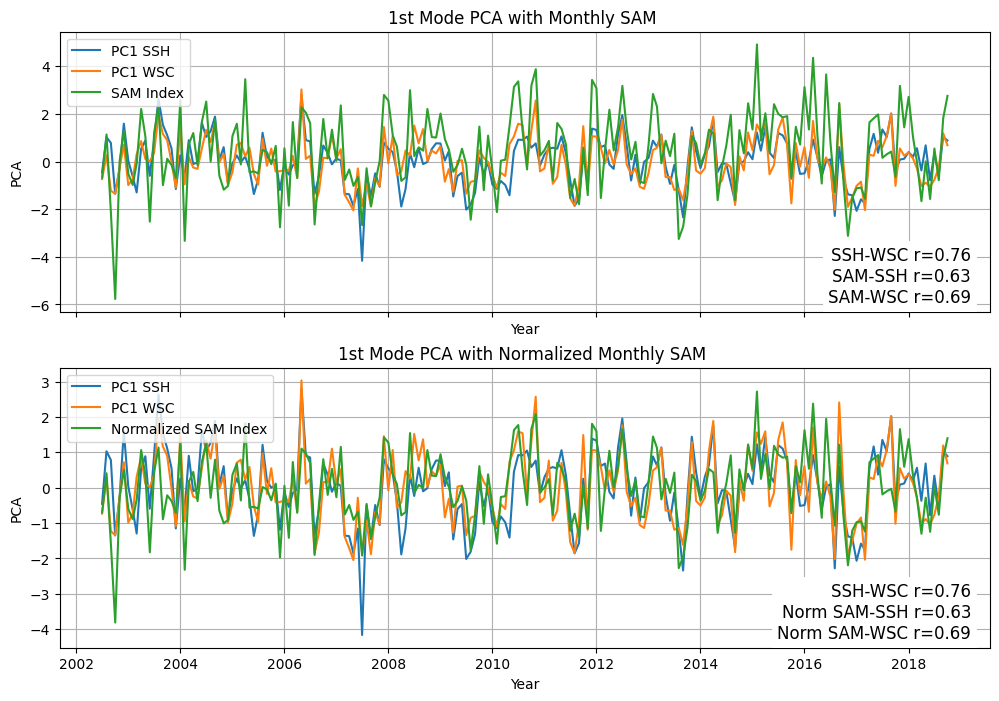

In [517]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(WSC_xa_masked.coords)

model.fit(dot_xa_masked, WSC_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values

#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))

# Select only the first mode (PC1)
pc1_scores1 = scores1.sel(mode=1)  # First PC for SSH
pc1_scores2 = scores2.sel(mode=1)  # First PC for WSC

pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

# Correlations
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores1.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores2.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores1.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores2.values)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot PCA1
ax1.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax1.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax1.plot(filtered_monthly_sam.time, filtered_monthly_sam, label="SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Monthly SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right',bbox=dict(facecolor='white', edgecolor='none'))


# Plot normalised SAM
ax2.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax2.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax2.plot(filtered_monthly_sam.time, normalized_monthly_sam, label="Normalized SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Monthly SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right',bbox=dict(facecolor='white', edgecolor='none'))



plt.show()

In [518]:
print(type(pc1_scores1))  # Should be <xarray.DataArray>
print(type(pc1_scores2))



<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


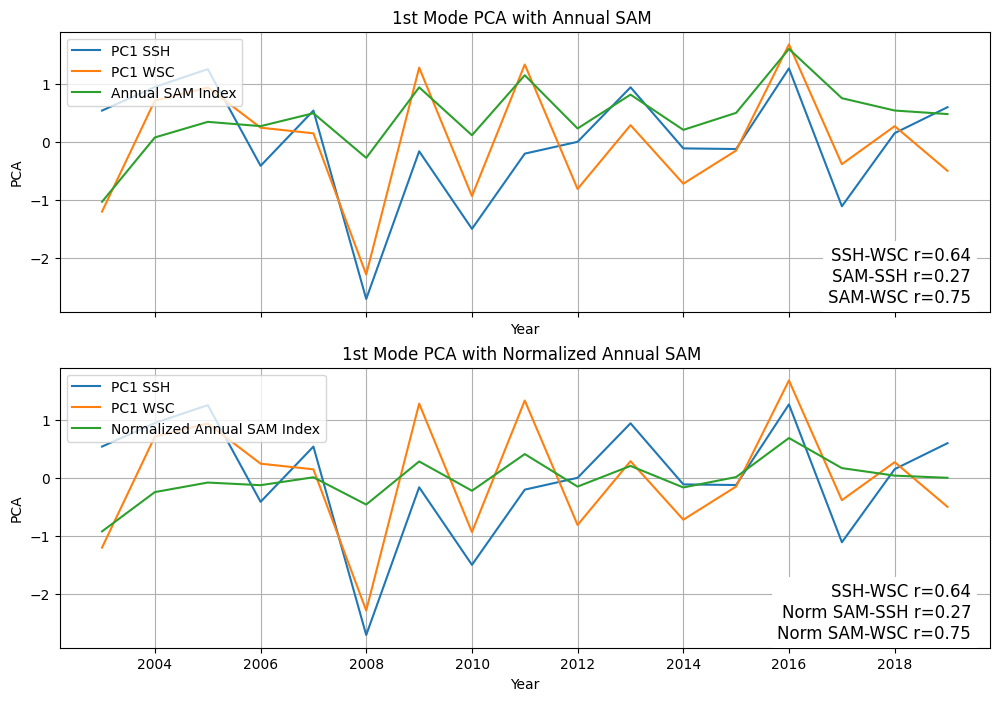

In [519]:
# Compute annual means for PC1 scores and SAM index
pc1_scores1_ann = scores1.sel(mode=1).resample(time='Y').mean()  # First PC for SSH
pc1_scores2_ann = scores2.sel(mode=1).resample(time='Y').mean()  # First PC for WSC
filtered_annual_sam = filtered_monthly_sam.resample(time='Y').mean()
normalized_annual_sam = normalized_monthly_sam.resample(time='Y').mean()

# Normalize PC1 scores
pc1_scores1_ann = (pc1_scores1_ann - pc1_scores1_ann.mean()) / pc1_scores1_ann.std()
pc1_scores2_ann = (pc1_scores2_ann - pc1_scores2_ann.mean()) / pc1_scores2_ann.std()

# Correlations using annual data
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1_ann.values, pc1_scores2_ann.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores1_ann.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores2_ann.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores1_ann.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores2_ann.values)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot PCA1 with annual SAM
ax1.plot(pc1_scores1_ann.time, pc1_scores1_ann, label="PC1 SSH")
ax1.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax1.plot(filtered_annual_sam.time, filtered_annual_sam, label="Annual SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Annual SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

# Plot PCA1 with normalized annual SAM
ax2.plot(pc1_scores1_ann.time, pc1_scores1_ann, label="PC1 SSH")
ax2.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax2.plot(normalized_annual_sam.time, normalized_annual_sam, label="Normalized Annual SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Annual SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

plt.show()


In [520]:
# Assign a name if missing
if dot_xa_masked.name is None:
    dot_xa_masked.name = "SSH"
if WSC_xa_masked.name is None:
    WSC_xa_masked.name = "WSC"

print(dot_xa_masked.name)
print(WSC_xa_masked.name)
print(dot_xa_masked.coords)

ssh_var = (dot_xa_masked.name) # Get SSH variable name
wsc_var = (WSC_xa_masked.name)
print(ssh_var)
print(wsc_var)

SSH
WSC
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
SSH
WSC


In [521]:

# Define seasons based on months
seasons = {
    'SPR': [9, 10, 11],  # SON (Spring in SH)
    'SUM': [12, 1, 2],   # DJF (Summer in SH)
    'AUT': [3, 4, 5],    # MAM (Autumn in SH)
    'WIN': [6, 7, 8]     # JJA (Winter in SH)
}

def seasonal_avg(ds):
    """Compute seasonal averages for a given dataset."""
    seasonal_data = {}
    for season, months in seasons.items():
        season_ds = ds.where(ds['time'].dt.month.isin(months), drop=True)
        seasonal_mean = season_ds.groupby("time.year").mean(dim="time")
        seasonal_data[season] = seasonal_mean
    return seasonal_data

# Compute seasonal means directly
ssh_seasonal = seasonal_avg(dot_xa_masked)
wsc_seasonal = seasonal_avg(WSC_xa_masked)

# Rename for MCA analysis
spr_ann = ssh_seasonal['SPR'], wsc_seasonal['SPR']
sum_ann = ssh_seasonal['SUM'], wsc_seasonal['SUM']
aut_ann = ssh_seasonal['AUT'], wsc_seasonal['AUT']
win_ann = ssh_seasonal['WIN'], wsc_seasonal['WIN']


In [522]:
print(len(ssh_seasonal['AUT']))
print(len(wsc_seasonal['WIN']))

16
17


In [523]:
print(ssh_seasonal['AUT'].year)

<xarray.DataArray 'year' (year: 16)> Size: 128B
array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])
Coordinates:
  * year     (year) int64 128B 2003 2004 2005 2006 2007 ... 2015 2016 2017 2018


In [524]:
print(len(ssh_seasonal['AUT']))
print(len(wsc_seasonal['AUT']))
print(len(normalized_sams['AUT']))

16
16
16


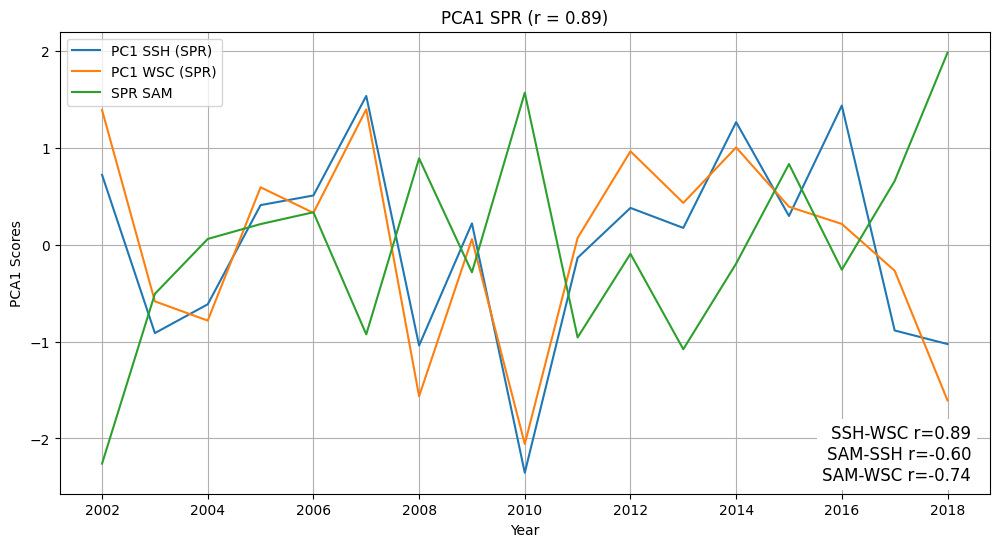

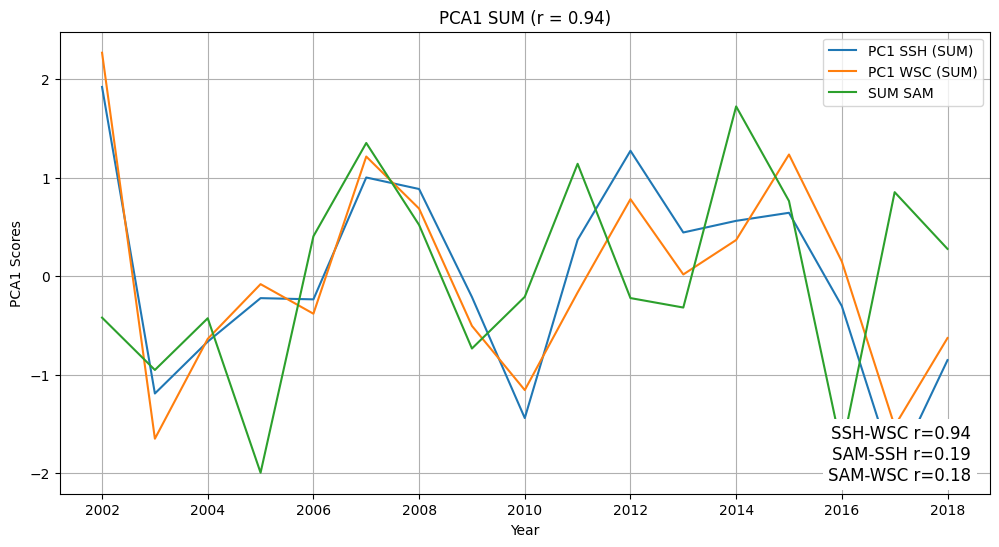

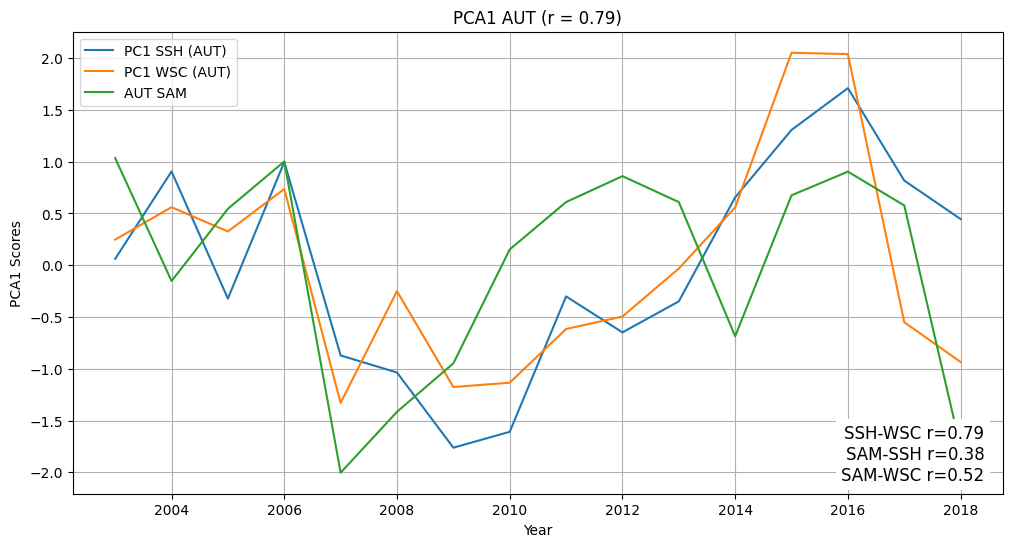

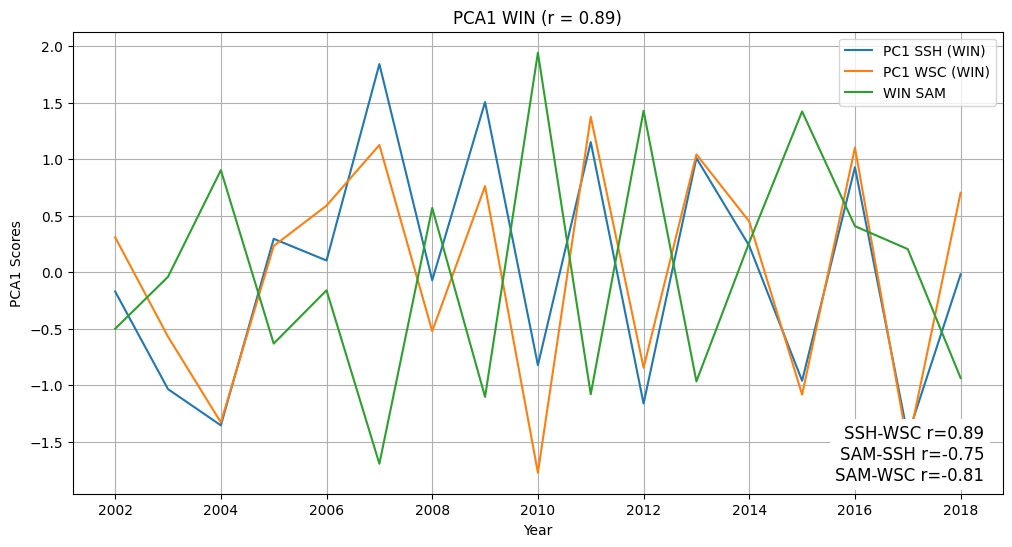

In [525]:
import scipy.stats
import matplotlib.pyplot as plt

seasons = ['SPR', 'SUM', 'AUT', 'WIN']

for season in seasons:
    # Extract seasonal data
    ssh_season = ssh_seasonal[season]
    wsc_season = wsc_seasonal[season]
    sam_season = normalized_sams[season]  # Assuming `normalized_sams` has seasonal SAM index

    # Fit the MCA model for the current season
    model = xe.cross.MCA(n_modes=4, standardize=True)
    model.fit(ssh_season, wsc_season, dim='year')
    comps1, comps2 = model.components()
    scores1, scores2 = model.scores()

    # Extract PCA1 scores for SSH and WSC
    pc1_scores1 = scores1.sel(mode=1)
    pc1_scores2 = scores2.sel(mode=1)

    # Normalize PCA1 scores
    pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
    pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

    # Compute Pearson Correlations
    r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
    r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(sam_season.values, pc1_scores1.values)
    r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(sam_season.values, pc1_scores2.values)

    # Compute Spearman Correlations
    r_spear_ssh_wsc, _ = scipy.stats.spearmanr(pc1_scores1.values, pc1_scores2.values)
    r_spear_sam_ssh, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores1.values)
    r_spear_sam_wsc, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores2.values)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(ssh_season.year, pc1_scores1, label=f'PC1 SSH ({season})')
    ax.plot(wsc_season.year, pc1_scores2, label=f'PC1 WSC ({season})')
    ax.plot(sam_season.year, sam_season, label=f'{season} SAM')

    # Add title, labels, and grid
    ax.set_title(f'PCA1 {season} (r = {r_ssh_wsc:.2f})')
    ax.set_xlabel('Year')
    ax.set_ylabel('PCA1 Scores')
    ax.legend()
    ax.grid(True)

    # Add correlation text
    correlation_text = (f"SSH-WSC r={r_ssh_wsc:.2f}\n"
                        f"SAM-SSH r={r_sam_ssh:.2f}\n"
                        f"SAM-WSC r={r_sam_wsc:.2f}")
    ax.text(0.98, 0.02, correlation_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

    plt.show()


In [526]:
#climatology for WSC, stresses (meridional and zonal), SIDC
# tau_x_wsc = rho_a*Cd_a*U_wsc*u10_wsc #zonal wind
# tau_y_wsc = rho_a*Cd_a*U_wsc*v10_wsc #meridional wind

#calculate sea ice drift stress
# tau_x_sid = rho_sw*Cd_w*U_ice*seaice_masked_u #zonal drift stress
# tau_y_sid = rho_sw*Cd_w*U_ice*seaice_masked_v #meridional drift stress

#WSC_xa_masked - WSC
#sid_curl_xa_masked - SIDC

#calculate tau_ice_water and tau_air_water
# tau_ice_water = ws_curl_final
# tau_air_water = sid_curl_final



In [527]:
print(tau_ds['tau_x_wsc'])

<xarray.DataArray 'tau_x_wsc' (time: 196, lon: 64, lat: 360)> Size: 36MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.02068101, 0.01995691, 0.01893414, ..., 0.02478185,
         0.02406133, 0.02285532],
        [0.02073882, 0.02002566, 0.01897176, ..., 0.02542477,
         0.02491941, 0.02391698],
        [0.02081135, 0.01977531, 0.01851727, ..., 0.02508504,
         0.02510456, 0.0242639 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.08323747, 0.08019502, 0.07777438,

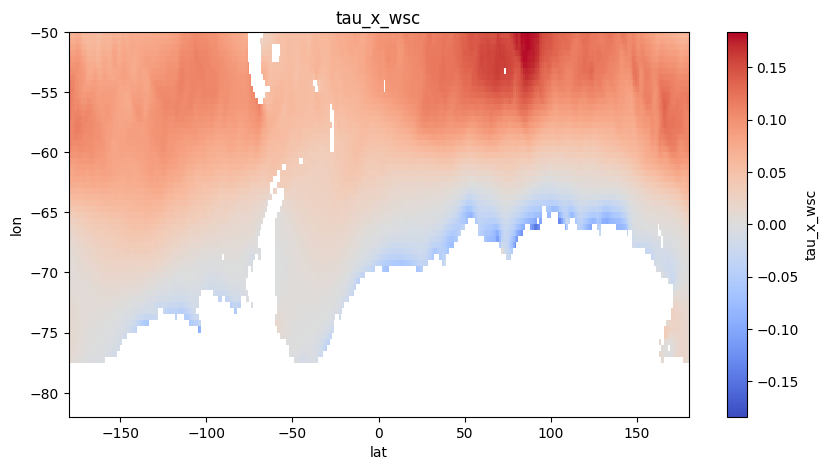

In [528]:
# Select one year of data (e.g., 2010)
variable = tau_ds['tau_x_wsc']
variable_name = variable.name
one_year_data = (variable.sel(time=slice("2018-01-01", "2018-12-31")))

# Plot the mean over time to visualize annual SIDC distribution
plt.figure(figsize=(10, 5))
one_year_data.mean(dim="time").plot(cmap="coolwarm")  # Adjust colormap if needed
plt.title(f"{variable_name}")

plt.show()


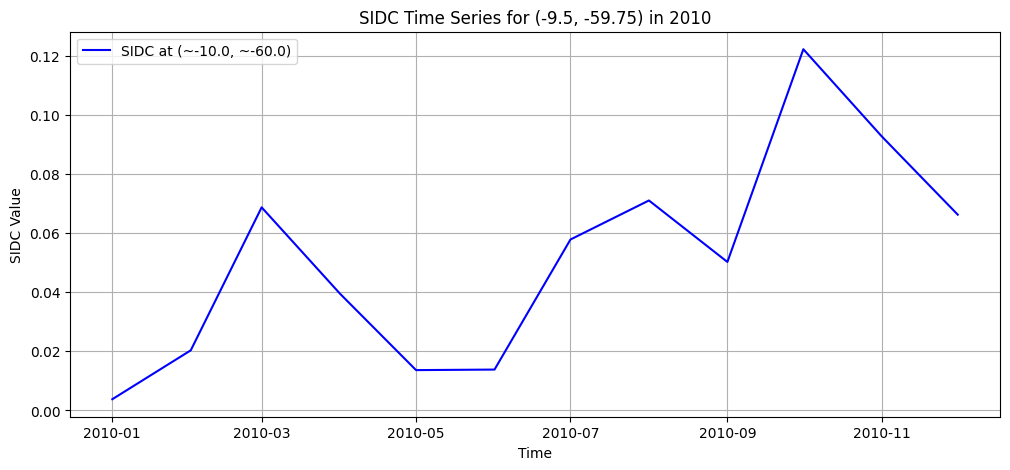

In [529]:
import xarray as xr
import matplotlib.pyplot as plt

# Define the approximate location
latitude = -10.0   # Example latitude
longitude = -60.0 # Example longitude

# Find the nearest available lat/lon
nearest_point = variable.sel(lat=latitude, lon=longitude, method="nearest")

# Now, slice the time range for one year (e.g., 2010)
one_year_data = nearest_point.sel(time=slice("2010-01-01", "2010-12-31"))

# Extract the exact coordinates used
nearest_lat = nearest_point.lat.values
nearest_lon = nearest_point.lon.values

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(one_year_data.time, one_year_data, label=f"SIDC at (~{latitude}, ~{longitude})", color="b")
plt.xlabel("Time")
plt.ylabel("SIDC Value")
plt.title(f"SIDC Time Series for ({nearest_lat}, {nearest_lon}) in 2010")
plt.legend()
plt.grid()
plt.show()

